# Hotel Reservation Cancellation Prediction


> This repository is part of a professional Data Science portfolio demonstrating applied machine learning for real-world business problems in the hospitality industry.


## Content Of This Notebook:
* Data Importing
* Overview to Dataset
* Exploratory Data Analysis (EDA)
  * Univariate (with and without Target)
  * Multivariate (with and without Target)
* Feature Engineering
  * Target Variable Encoding (booking_status)
  * PCA Feature Combination (no_of_adults + no_of_children, no_of_weekend_nights + no_of_week_nights)
  * Monthly Categorization (arrival_month)
  * Historical Rate Calculation (cancellations_rate)
* Feature Selection
* Preprocessing Pipeline
  * SCALING (RobustScaler)
  * Categorical Encoding (One-Hot Encoding)
* Modeling
  * Random Forest Classifier
  * XGBoost
  * Logistic Regression
  * SVC
  * CatBoost Classifier
* Solution Of The Imbalanced Dataset Problem
* Under-Sampling and Over-Sampling (SVM-SMOTE) Methods
  * Under-Sampled Model Evaluation
  * Over-Sampled Model Evaluation
* Evaluating Models With Different Metrics
  * Accuracy, Precision, Recall, F1-Score
  * Specificity and Sensitivity Analysis
  * Confusion Matrix Evaluation
* Comparing ML Algorithms
  * Performance Comparison Across Sampling Methods
  * Business Impact Assessment
* Ensemble Learning (Voting Classifier)
  * Weighted Ensemble Configuration
  * Under-Sampled vs Over-Sampled Ensemble Performance
* Conclusion and Model Selection Rationale


## Data Collection

**Origin and Source**
This analysis utilizes the publicly available Hotel Booking Demand dataset from two hotels in Portugal, providing real-world validation of the methodology:

- **H1**: A resort hotel in the Algarve region (southern Portugal, tourism-focused)
- **H2**: A city hotel in Lisbon (urban business/leisure mix)
- **Period**: Bookings scheduled between July 2015 - August 2017 (119,000+ observations)
- **Data Integrity**: Personally identifiable information removed for privacy; all data anonymized for research use

*Source: Hotel booking demand datasets [ResearchGate Publication](https://www.researchgate.net/publication/329286343_Hotel_booking_demand_datasets)*

**Note**: While this specific implementation uses historical Portuguese hotel data, the methodology, feature engineering, and model architecture are directly applicable to hotel operations globally, particularly addressing the universal challenge of cancellation-driven revenue loss.

* `Booking_ID`: Unique identifier of each booking
* `no_of_adults`: Number of adults
* `no_of_children`: Number of children
* `no_of_weekend_nights`: Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel
* `no_of_week_nights`: Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel
* `type_of_meal_plan`: Type of meal plan booked by the customer
* `required_car_parking_space`: Does the customer require a car parking space? (0 - No, 1 - Yes)
* `room_type_reserved`: Type of room reserved by the customer (values encoded by INN Hotels)
* `lead_time`: Number of days between the date of booking and the arrival date
* `arrival_year`: Year of arrival date
* `arrival_month`: Month of arrival date
* `arrival_date`: Day of the month of arrival
* `market_segment_type`: Market segment designation
* `repeated_guest`: Is the customer a repeated guest? (0 - No, 1 - Yes)
* `no_of_previous_cancellations`: Number of previous bookings that were canceled by the customer prior to the current booking
* `no_of_previous_bookings_not_canceled`: Number of previous bookings not canceled by the customer prior to the current booking
* `avg_price_per_room`: Average price per day of the reservation (in euros); prices are dynamic
* `no_of_special_requests`: Total number of special requests made by the customer (e.g., high floor, view from the room, etc.)
* `booking_status`: Flag indicating if the booking was canceled or not

## Import Libraries

In [223]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


MY_LIB_PATH = r"/home/seba/Documentos/Data Science Projects/seba-libs"
sys.path.append(MY_LIB_PATH)

from exploratory_data_analysis import ExploratoryDataAnalysis
from non_categorical_feature_engineering import NonCategoricalFeatureEngineering
from categorical_feature_engineering import CategoricalFeatureEngineering
from general_feature_engineering import GeneralFeatureEngineering

## Data Cleaning

In [224]:
df = pd.read_csv("datasets/Hotel Reservations.csv")

print("shape of dataset :",df.shape)
df.head()

shape of dataset : (36275, 19)


,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


`Booking_ID`
- **Modeling Insight** (*priority: low*): Identifier variable with no predictive power — should be removed to prevent data leakage.
- **Business Insight**: no relevant information.

In [225]:
# I will drop a NON meaningful feature
df.drop(columns='Booking_ID', inplace=True)

## Data Quality Analysis

#### Handling Missing Values

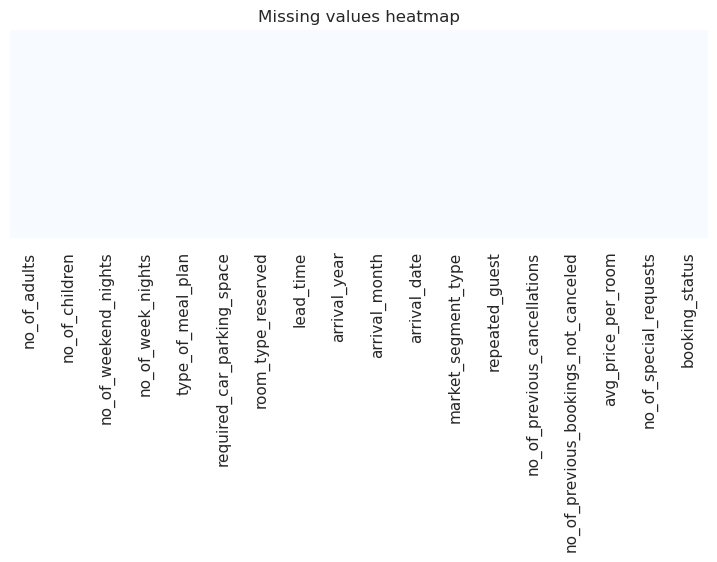

In [226]:
ExploratoryDataAnalysis.plot_missing_values_heatmap(df)

>No NaNs detected

#### Checking Duplicate Rows

In [227]:
ExploratoryDataAnalysis.has_df_duplicated_rows(df)
# Note: Standard code:
# sns.heatmap(df.isnull(), yticklabels=False, cbar = False, cmap = "Blues").set_title("Missing values heatmap")

🔍 Row Duplicated Analysis
⚠️  10275 duplicates found (28.33%)
    Total rows affected: 10,275/36,275


{'total_rows': 36275,
 'duplicates_count': 10275,
 'duplicates_pct': 0.2832529290144728}

> We have no duplicated rows

#### Checking Outlier Values

In [228]:
def automated_outlier_detection(df, exclude_columns=None, min_unique_values=3,
                               show_exclusion_info=True, include_zero_outliers=False):
    """
    Automated outlier detection using the Interquartile Range (IQR) method with intelligent filtering.
    
    The IQR method identifies outliers as values that fall below Q1 - 1.5*IQR or above Q3 + 1.5*IQR,
    where Q1 is the 25th percentile, Q3 is the 75th percentile, and IQR = Q3 - Q1.
    
    This simplified version focuses on core outlier detection without rare binary variable filtering.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame containing the data to analyze
    exclude_columns : list, optional
        Manual list of column names to exclude from analysis
    min_unique_values : int, default=3
        Minimum number of unique values required for a variable to be included in analysis.
        Variables with fewer unique values will be automatically excluded.
    show_exclusion_info : bool, default=True
        Whether to display detailed information about automatically excluded variables
    include_zero_outliers : bool, default=False
        Whether to include variables with zero outliers in the final results
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame containing outlier analysis results with columns:
        - Feature: Variable name
        - DataType: Data type of the variable
        - Method: Detection method used ('IQR' or '3-sigma')
        - Outlier Count: Number of outliers detected
        - Outlier %: Percentage of outliers in the dataset
        - Lower Bound: Calculated lower bound for outliers
        - Upper Bound: Calculated upper bound for outliers
        - Min Value: Minimum value in the variable
        - Max Value: Maximum value in the variable
        - IQR: Interquartile range value
    
    Methodology:
    ------------
    1. Selects numeric variables from the DataFrame
    2. Applies intelligent filtering to exclude unsuitable variables:
       - Variables with insufficient unique values
       - Constant variables (zero variance)
    3. For each suitable variable, calculates outliers using:
       - Standard IQR method for variables with sufficient variability
       - 3-sigma method (mean ± 3*std) for variables with IQR = 0
    4. Returns comprehensive results sorted by outlier count
    
    Example:
    --------
    >>> results = automated_outlier_detection(df=employee_data, min_unique_values=3)
    >>> print(results)
    """
    
    # Select numeric columns
    numeric_columns = df.select_dtypes(include=['int64', 'int32', 'float64', 'float32']).columns.tolist()
    
    # Exclude manually specified columns
    if exclude_columns:
        numeric_columns = [col for col in numeric_columns if col not in exclude_columns]
    
    # Intelligent automatic filtering system
    excluded_columns = []
    columns_to_analyze = []
    
    for col in numeric_columns:
        unique_count = df[col].nunique()
        
        exclusion_reason = None
        
        # 1. Check minimum unique values requirement
        if unique_count < min_unique_values:
            exclusion_reason = f"insufficient_unique_values ({unique_count} < {min_unique_values})"
        
        # 2. Always exclude constants (zero variance)
        elif unique_count <= 1:
            exclusion_reason = "constant_variable"
        
        if exclusion_reason:
            excluded_columns.append((col, exclusion_reason))
        else:
            columns_to_analyze.append(col)
    
    # Display exclusion information
    if show_exclusion_info and excluded_columns:
        print(f"🔍 Analyzing {len(columns_to_analyze)} of {len(numeric_columns)} numeric variables")
        print("📊 Automatically excluded variables:")
        for col, reason in excluded_columns:
            print(f"   - {col}: {reason}")
    elif show_exclusion_info:
        print(f"🔍 Analyzing {len(columns_to_analyze)} numeric variables")
        print("✅ No variables were automatically excluded")
    
    # Outlier analysis
    outlier_results = []
    
    for feature in columns_to_analyze:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        
        # Choose detection method based on data variability
        if IQR == 0:
            # Alternative method for low-variability variables
            mean_val = df[feature].mean()
            std_val = df[feature].std()
            lower_bound = mean_val - 3 * std_val if std_val > 0 else mean_val
            upper_bound = mean_val + 3 * std_val if std_val > 0 else mean_val
            method_used = "3-sigma"
        else:
            # Standard IQR method
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            method_used = "IQR"
        
        # Detect outliers
        outliers_mask = (df[feature] < lower_bound) | (df[feature] > upper_bound)
        outliers = df[feature][outliers_mask]
        outlier_count = len(outliers)
        outlier_percentage = (outlier_count / len(df)) * 100
        
        # Include in results based on user preference
        if outlier_count > 0 or include_zero_outliers:
            outlier_results.append({
                "Feature": feature,
                "DataType": str(df[feature].dtype),
                "Method": method_used,
                "Outlier Count": outlier_count,
                "Outlier %": f"{outlier_percentage:.2f}%",
                "Lower Bound": round(lower_bound, 2),
                "Upper Bound": round(upper_bound, 2),
                "Min Value": df[feature].min(),
                "Max Value": df[feature].max(),
                "IQR": round(IQR, 2) if IQR > 0 else 0
            })
    
    # Create and sort results DataFrame
    result_df = pd.DataFrame(outlier_results)
    if not result_df.empty:
        result_df = result_df.sort_values('Outlier Count', ascending=False)
    
    return result_df

In [229]:
# The IQR method identifies outliers as values that fall below Q1 - 1.5*IQR or above Q3 + 1.5*IQR,
#  where Q1 is the 25th percentile, Q3 is the 75th percentile, and IQR = Q3 - Q1.
# This simplified version focuses on core outlier detection without rare binary variable filtering.

results_default = automated_outlier_detection(
    df=df,
    min_unique_values=3,
    show_exclusion_info=True)

results_default

🔍 Analyzing 11 of 14 numeric variables
📊 Automatically excluded variables:
   - required_car_parking_space: insufficient_unique_values (2 < 3)
   - arrival_year: insufficient_unique_values (2 < 3)
   - repeated_guest: insufficient_unique_values (2 < 3)


,Feature,DataType,Method,Outlier Count,Outlier %,Lower Bound,Upper Bound,Min Value,Max Value,IQR
7,avg_price_per_room,float64,IQR,1696,4.68%,20.75,179.55,0.0,540.0,39.7
4,lead_time,int64,IQR,1331,3.67%,-146.50,289.50,0.0,443.0,109.0
1,no_of_children,int64,3-sigma,1080,2.98%,-1.10,1.31,0.0,10.0,0.0
8,no_of_special_requests,int64,IQR,761,2.10%,-1.50,2.50,0.0,5.0,1.0
3,no_of_week_nights,int64,IQR,324,0.89%,-2.00,6.00,0.0,17.0,2.0
6,no_of_previous_bookings_not_canceled,int64,3-sigma,267,0.74%,-5.11,5.42,0.0,58.0,0.0
0,no_of_adults,int64,3-sigma,155,0.43%,0.29,3.40,0.0,4.0,0.0
5,no_of_previous_cancellations,int64,3-sigma,140,0.39%,-1.08,1.13,0.0,13.0,0.0
2,no_of_weekend_nights,int64,IQR,21,0.06%,-3.00,5.00,0.0,7.0,2.0


In [230]:
results_default.Feature

7                      avg_price_per_room
4                               lead_time
1                          no_of_children
8                  no_of_special_requests
3                       no_of_week_nights
6    no_of_previous_bookings_not_canceled
0                            no_of_adults
5            no_of_previous_cancellations
2                    no_of_weekend_nights
Name: Feature, dtype: object

#### Data Quality Insights: Missing Values, Duplicates and Outliers

**Missing Values**
-   no detected 

**Duplicated Records**
-   no detected

**Outlier Values**  
We have outliers as values that fall below Q1 - 1.5*IQR or above Q3 + 1.5*IQR
Top 5 features with less than 5% of their data: `avg_price_per_room`,`lead_time`,`no_of_children`,`no_of_special_requests`,`no_of_week_nights`.

> At the moment we just recomend an scaller as preprocess only

## Exploratory Data Analysis (EDA)

### 1. Preliminary Analysis and Structure

In [231]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          36275 non-null  int64  
 1   no_of_children                        36275 non-null  int64  
 2   no_of_weekend_nights                  36275 non-null  int64  
 3   no_of_week_nights                     36275 non-null  int64  
 4   type_of_meal_plan                     36275 non-null  object 
 5   required_car_parking_space            36275 non-null  int64  
 6   room_type_reserved                    36275 non-null  object 
 7   lead_time                             36275 non-null  int64  
 8   arrival_year                          36275 non-null  int64  
 9   arrival_month                         36275 non-null  int64  
 10  arrival_date                          36275 non-null  int64  
 11  market_segment_

In [232]:
df.describe()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
count,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000
mean,1.844962,0.105279,0.810724,2.204300,0.030986,85.232557,2017.820427,7.423653,15.596995,0.025637,0.023349,0.153411,103.423539,0.619655
std,0.518715,0.402648,0.870644,1.410905,0.173281,85.930817,0.383836,3.069894,8.740447,0.158053,0.368331,1.754171,35.089424,0.786236
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,17.000000,2018.000000,5.000000,8.000000,0.000000,0.000000,0.000000,80.300000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,57.000000,2018.000000,8.000000,16.000000,0.000000,0.000000,0.000000,99.450000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,126.000000,2018.000000,10.000000,23.000000,0.000000,0.000000,0.000000,120.000000,1.000000
max,4.000000,10.000000,7.000000,17.000000,1.000000,443.000000,2018.000000,12.000000,31.000000,1.000000,13.000000,58.000000,540.000000,5.000000


In [233]:
categorical_columns, non_categorical_columns = GeneralFeatureEngineering.detect_categorical_and_non_categorical_columns(df)

Categorical Columns:     ['type_of_meal_plan', 'room_type_reserved', 'market_segment_type', 'booking_status']
Non-Categorical Columns: ['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 'required_car_parking_space', 'lead_time', 'arrival_year', 'arrival_month', 'arrival_date', 'repeated_guest', 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled', 'avg_price_per_room', 'no_of_special_requests']


In [234]:
df.head(3)

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled


### 2. Univariate Analysis

#### 2.1. Non-Categorical Variables

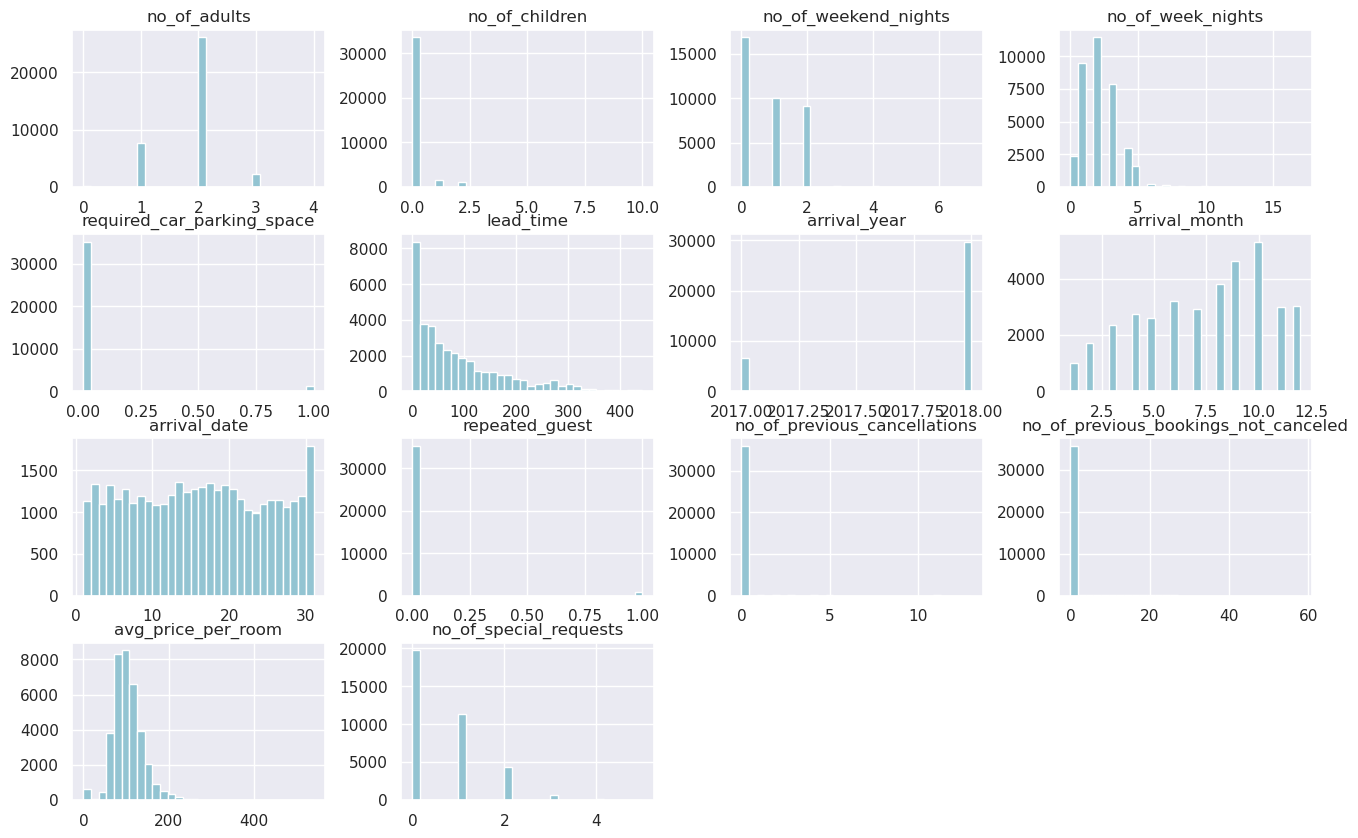

In [235]:
# Plot non categotical Variables
sns.set_style("darkgrid")
df[non_categorical_columns].hist(bins = 30, figsize=(16,10), color = '#93c4d2')
plt.show()

In [236]:
import pandas as pd

def check_skewness(data, numerical_features, highlight=True, sort=True):
    """
    Analiza la asimetría (skewness) de las variables numéricas en un DataFrame.

    Parameters
    ----------
    data : pandas.DataFrame
        Dataset de entrada.
    numerical_features : list
        Lista con los nombres de las variables numéricas.
    highlight : bool, optional (default=True)
        Si True, resalta con colores las variables con asimetría moderada o alta.
    sort : bool, optional (default=True)
        Si True, ordena las variables por |skewness| de mayor a menor.

    Returns
    -------
    skewed_features : list
        Lista de features con asimetría moderada o alta.
    skew_df : pandas.DataFrame
        DataFrame con los valores de skewness y clasificación.
    """

    # Calcular skewness
    skewness_dict = {feature: data[feature].skew(skipna=True) for feature in numerical_features}
    skew_df = pd.DataFrame.from_dict(skewness_dict, orient="index", columns=["Skewness"])

    # Clasificación
    def classify_skew(val):
        val_abs = abs(val)
        if val_abs >= 1:
            return "Highly skewed"
        elif val_abs >= 0.5:
            return "Moderately skewed"
        else:
            return "Approximately symmetric"

    skew_df["Remark"] = skew_df["Skewness"].apply(classify_skew)

    # Ordenar si corresponde
    if sort:
        skew_df = skew_df.reindex(skew_df["Skewness"].abs().sort_values(ascending=False).index)

    # Output en consola
    print("\n🔍 Skewness for dataset:")
    print("-"*70)
    print(f"{'Feature':<30} | {'Skewness':<10} | {'Remark'}")
    print("-"*70)

    skewed_features = []
    for feature, row in skew_df.iterrows():
        skew, remark = row["Skewness"], row["Remark"]

        if remark == "Highly skewed":
            color = "\033[91m" if highlight else ""
        elif remark == "Moderately skewed":
            color = "\033[93m" if highlight else ""
        else:
            color = ""
        endc = "\033[0m" if color else ""

        print(f"{color}{feature:<30} | {skew:>+10.4f} | {remark}{endc}")

        if remark != "Approximately symmetric":
            skewed_features.append(feature)

    print("-"*70)
    return skewed_features, skew_df

In [237]:
skewed_features, skew_df = check_skewness(data=df, numerical_features=non_categorical_columns)


🔍 Skewness for dataset:
----------------------------------------------------------------------
Feature                        | Skewness   | Remark
----------------------------------------------------------------------
no_of_previous_cancellations   |   +25.1999 | Highly skewed
no_of_previous_bookings_not_canceled |   +19.2502 | Highly skewed
repeated_guest                 |    +6.0029 | Highly skewed
required_car_parking_space     |    +5.4136 | Highly skewed
no_of_children                 |    +4.7103 | Highly skewed
arrival_year                   |    -1.6697 | Highly skewed
no_of_week_nights              |    +1.5994 | Highly skewed
lead_time                      |    +1.2925 | Highly skewed
no_of_special_requests         |    +1.1451 | Highly skewed
no_of_weekend_nights           |    +0.7376 | Moderately skewed
avg_price_per_room             |    +0.6671 | Moderately skewed
arrival_month                  |    -0.3482 | Approximately symmetric
no_of_adults                   |    

#### 🗒️ Insights for Non-Categorical Variables (Univariate)

**Modeling Insight** (*priority: high*):  
*Key Findings from Distributional Analysis:*

*   **Variables to Transform** (long tail distributions):
    `(no_of_previous_cancellations)`, `(no_of_previous_bookings_not_canceled)`, `(repeated_guest)`, `(required_car_parking_space)`, `(no_of_children)`, `(no_of_week_nights)`, `(lead_time)`, `(no_of_special_requests)`.
    These skewed distributions violate the normality assumptions of many models. It is recommended to apply logarithmic, Box-Cox, or binning transformations to reduce skewness and improve numerical stability.

*   **Moderately Skewed Variables**:
    `(no_of_weekend_nights)`, `(avg_price_per_room)`.
    These variables have a mild positive skew; evaluate logarithmic transformations or normalization depending on the model. For tree-based models, they can potentially remain unchanged.

*   **Approximately Symmetrical Variables**:
    `(arrival_month)`, `(no_of_adults)`, `(arrival_date)`.
    These variables can be kept as-is or normalized for models sensitive to scale (e.g., neural networks).

**Business Insight**:
The data profile shows a high concentration in variables related to previous customer behavior (`(no_of_previous_cancellations)`, `(no_of_previous_bookings_not_canceled)`, `(repeated_guest)`), indicating patterns of loyalty and cancellations. The proposed transformations will enhance the predictive capability and numerical stability of the models, preventing highly skewed variables from dominating the learning process.

#### 2.2. Categorical Variables

In [238]:
df[categorical_columns]

,type_of_meal_plan,room_type_reserved,market_segment_type,booking_status
0,Meal Plan 1,Room_Type 1,Offline,Not_Canceled
1,Not Selected,Room_Type 1,Online,Not_Canceled
2,Meal Plan 1,Room_Type 1,Online,Canceled
3,Meal Plan 1,Room_Type 1,Online,Canceled
4,Not Selected,Room_Type 1,Online,Canceled
...,...,...,...,...
36270,Meal Plan 1,Room_Type 4,Online,Not_Canceled
36271,Meal Plan 1,Room_Type 1,Online,Canceled
36272,Meal Plan 1,Room_Type 1,Online,Not_Canceled
36273,Not Selected,Room_Type 1,Online,Canceled


In [239]:
def univariate_categorical_analysis(data, columns, figsize=(5, 4), palette='viridis', vspace=0.3):
    """
    Univariate Categorical Analysis for Exploratory Data Analysis (EDA).

    This function visualizes the distribution of categorical variables in a dataset using horizontal bar plots,
    displaying both frequency and percentage for each category. It is designed for EDA workflows to quickly
    assess the balance and prevalence of categories in each feature.

    Parameters
    ----------
    data : pandas.DataFrame
        The input DataFrame containing the data to analyze.
    columns : list of str
        List of categorical column names to visualize.
    figsize : tuple of int, optional (default=(5, 4))
        Base figure size for each subplot (width, height).
    palette : str or list, optional (default='viridis')
        Seaborn color palette or list of colors for the bars.
    vspace : float, optional (default=0.3)
        Vertical spacing between rows of subplots.

    Returns
    -------
    None
        Displays the plots directly using matplotlib.

    Notes
    -----
    - Each subplot shows the frequency and percentage of each category for a given feature.
    - Missing values are displayed as 'NaN'.
    - The function automatically arranges subplots in a 2-column layout.
    - Useful for quickly identifying imbalanced categories and potential data quality issues.
    """
    sns.set_theme(style="whitegrid")

    n_cols = len(columns)
    n_rows = (n_cols + 1) // 2  # Calculate rows for 2-column layout
    
    # Calculate figure size based on number of rows and vertical spacing
    fig_width = figsize[0] * 2
    fig_height = figsize[1] * n_rows * (1 + vspace)
    
    fig, axes = plt.subplots(n_rows, 2, figsize=(fig_width, fig_height))
    axes = axes.flatten()  # Flatten for easy iteration
    
    fig.suptitle('Categorical Distributions', fontsize=18, fontweight='bold', y=0.98)
    
    for idx, column in enumerate(columns):
        if idx >= len(axes):  # Safety check
            break
            
        ax = axes[idx]
        
        # Get data and handle nulls
        column_data = data[column].copy().fillna('NaN')
        
        # Calculate frequencies and percentages
        frequencies = column_data.value_counts()
        total = len(column_data)
        percentages = (frequencies / total * 100).round(1)
        
        # Create horizontal bar plot
        colors = sns.color_palette(palette, len(frequencies))
        bars = ax.barh(range(len(frequencies)), frequencies.values, color=colors, alpha=0.8)
        
        # Set y-ticks and labels
        ax.set_yticks(range(len(frequencies)))
        ax.set_yticklabels(frequencies.index)
        
        # Add count and percentage values on bars
        for i, (value, percentage) in enumerate(zip(frequencies.values, percentages.values)):
            ax.text(value + value * 0.01, i, f'{value} ({percentage}%)', 
                   va='center', fontweight='bold', fontsize=11)
        
        ax.set_title(column, fontsize=14, fontweight='bold')
        ax.set_xlabel('Frequency')
        
        # Add some padding for text
        max_freq = max(frequencies.values)
        ax.set_xlim(0, max_freq * 1.15)
    
    # Hide empty subplots
    for idx in range(len(columns), len(axes)):
        axes[idx].set_visible(False)
    
    # Adjust layout with customizable vertical spacing
    plt.tight_layout()
    plt.subplots_adjust(top=0.92, hspace=vspace)  # Use the vspace parameter
    plt.show()

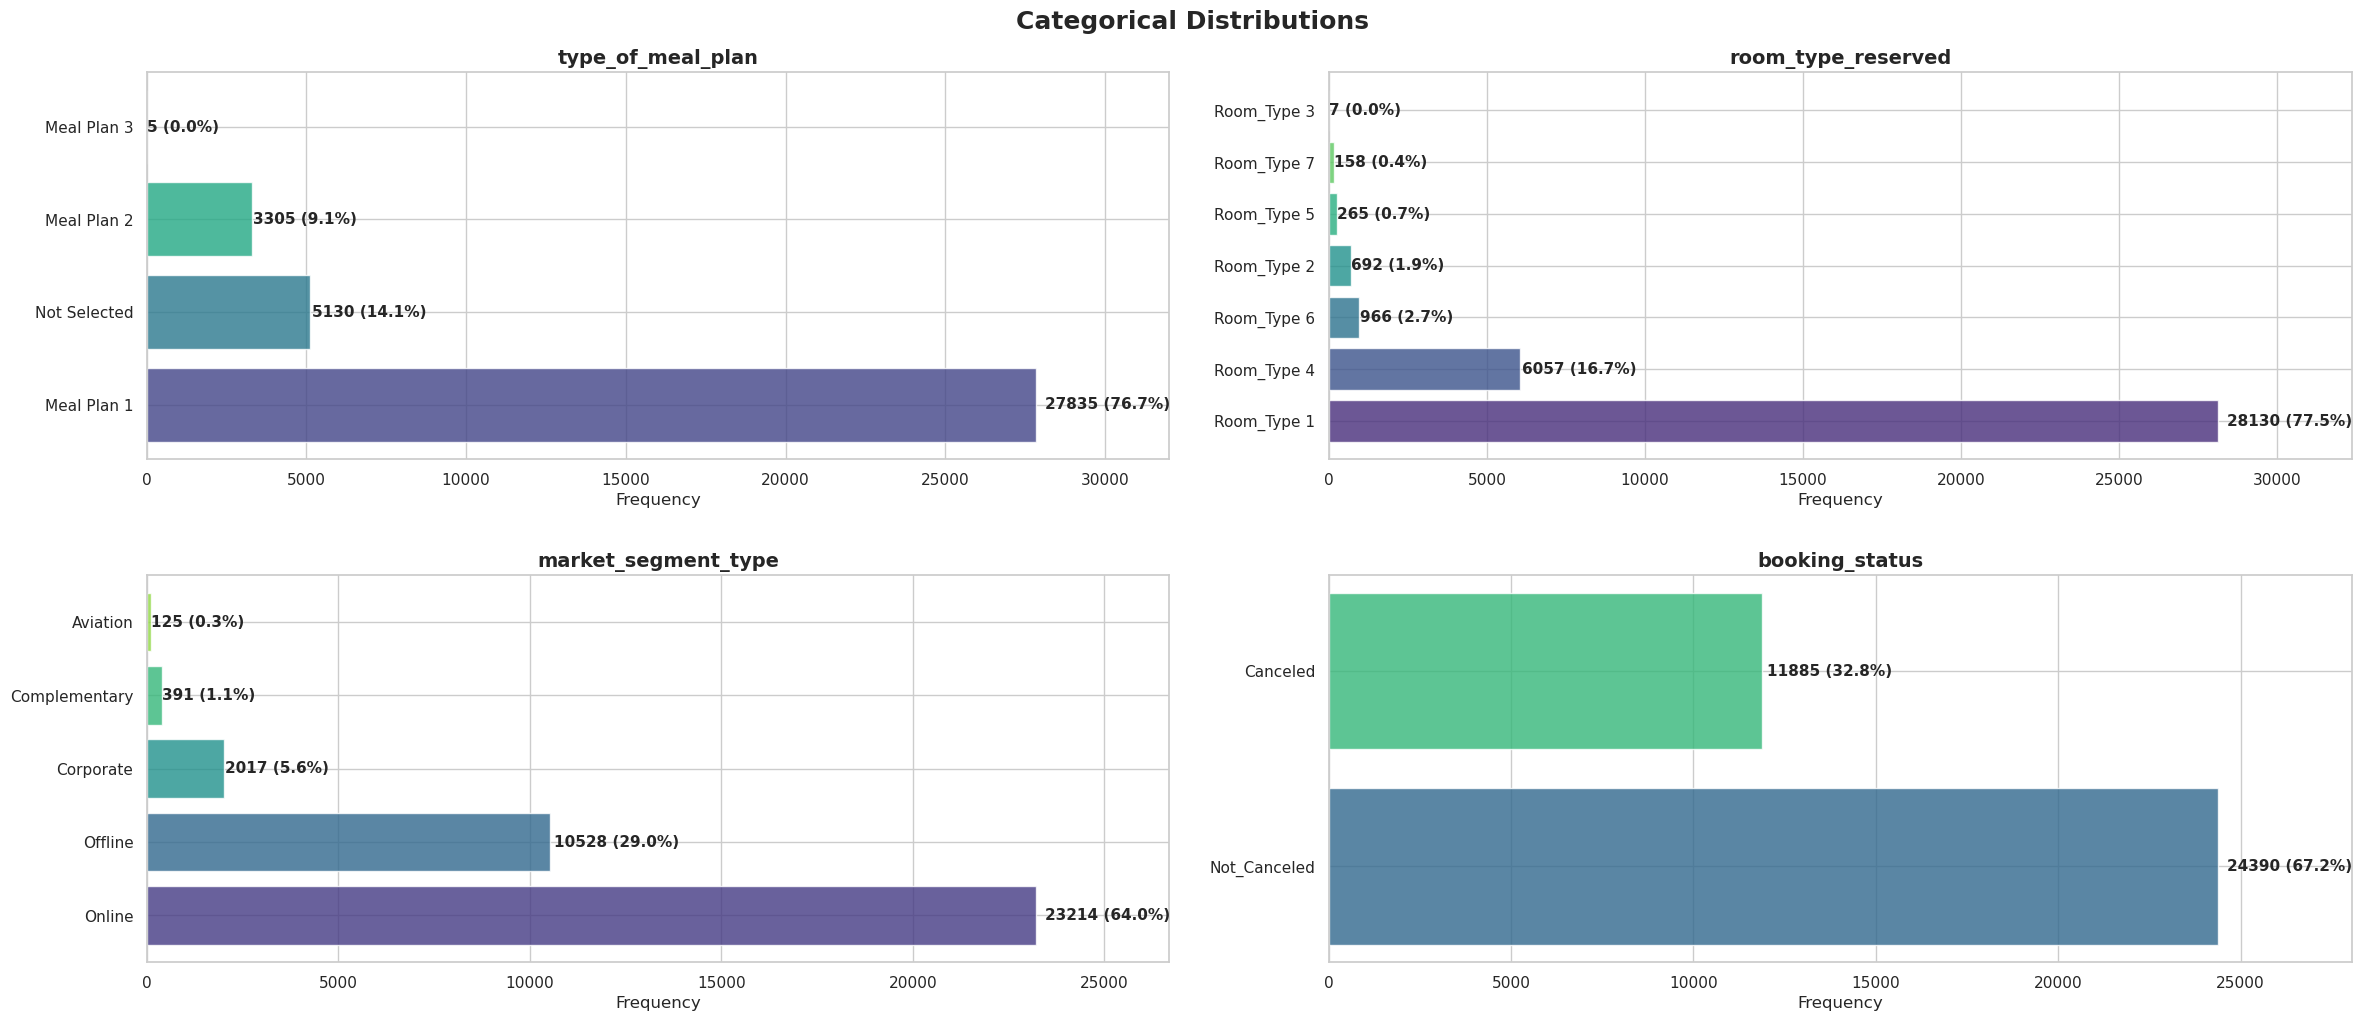

In [240]:
univariate_categorical_analysis(data=df, columns=categorical_columns, figsize=(12, 4))

#### 🗒️ Insights for Categorical Variables (Univariate)

`(type_of_meal_plan)`
- **Modeling Insight** (*priority: high*): Severe class imbalance with Meal Plan 1 (76.7%) dominating; requires encoding and potential class balancing techniques.
- **Business Insight**: Strong customer preference for Meal Plan 1, indicating it may be the most popular or standard offering.

`(room_type_reserved)`
- **Modeling Insight** (*priority: high*): Extreme class imbalance with Room_Type 1 (77.5%) dominating; consider encoding and evaluate impact of rare categories.
- **Business Insight**: Room_Type 1 is the clear customer preference, suggesting it's either the standard room or offers the best value.

`(market_segment_type)`
- **Modeling Insight** (*priority: medium*): Moderate imbalance with Online (64.0%) and Offline (29.0%) segments dominating; requires categorical encoding.
- **Business Insight**: Online channels drive most bookings, followed by offline channels, indicating digital marketing effectiveness.

`(booking_status)`
- **Modeling Insight** (*priority: high*): Target variable with class imbalance - 32.8% canceled (1) vs 67.2% not canceled (0); requires balancing techniques like SMOTE or class weights.
- **Business Insight**: Approximately one-third of bookings result in cancellations, indicating significant revenue protection opportunity.

**Global Preprocessing Summary**
- **Categorical Variables (One-Hot Encoding)**: `(type_of_meal_plan)`, `(room_type_reserved)`, `(market_segment_type)`
- **Target Imbalance**: `(booking_status)` (32.8% vs 67.2%) - apply SMOTE, class weights, or other balancing techniques
- **Other Preprocessing Notes**: All categorical variables show significant class imbalance; consider rare category handling or target encoding

### 3. Bivariate/Multivariate Analysis with Target
- Distribution comparisons (numerical vs target)
- Target proportions by category (categorical vs target)
- Correlation matrices (Pearson, Spearman)

#### 3.1. Between Non-Categorical Variables

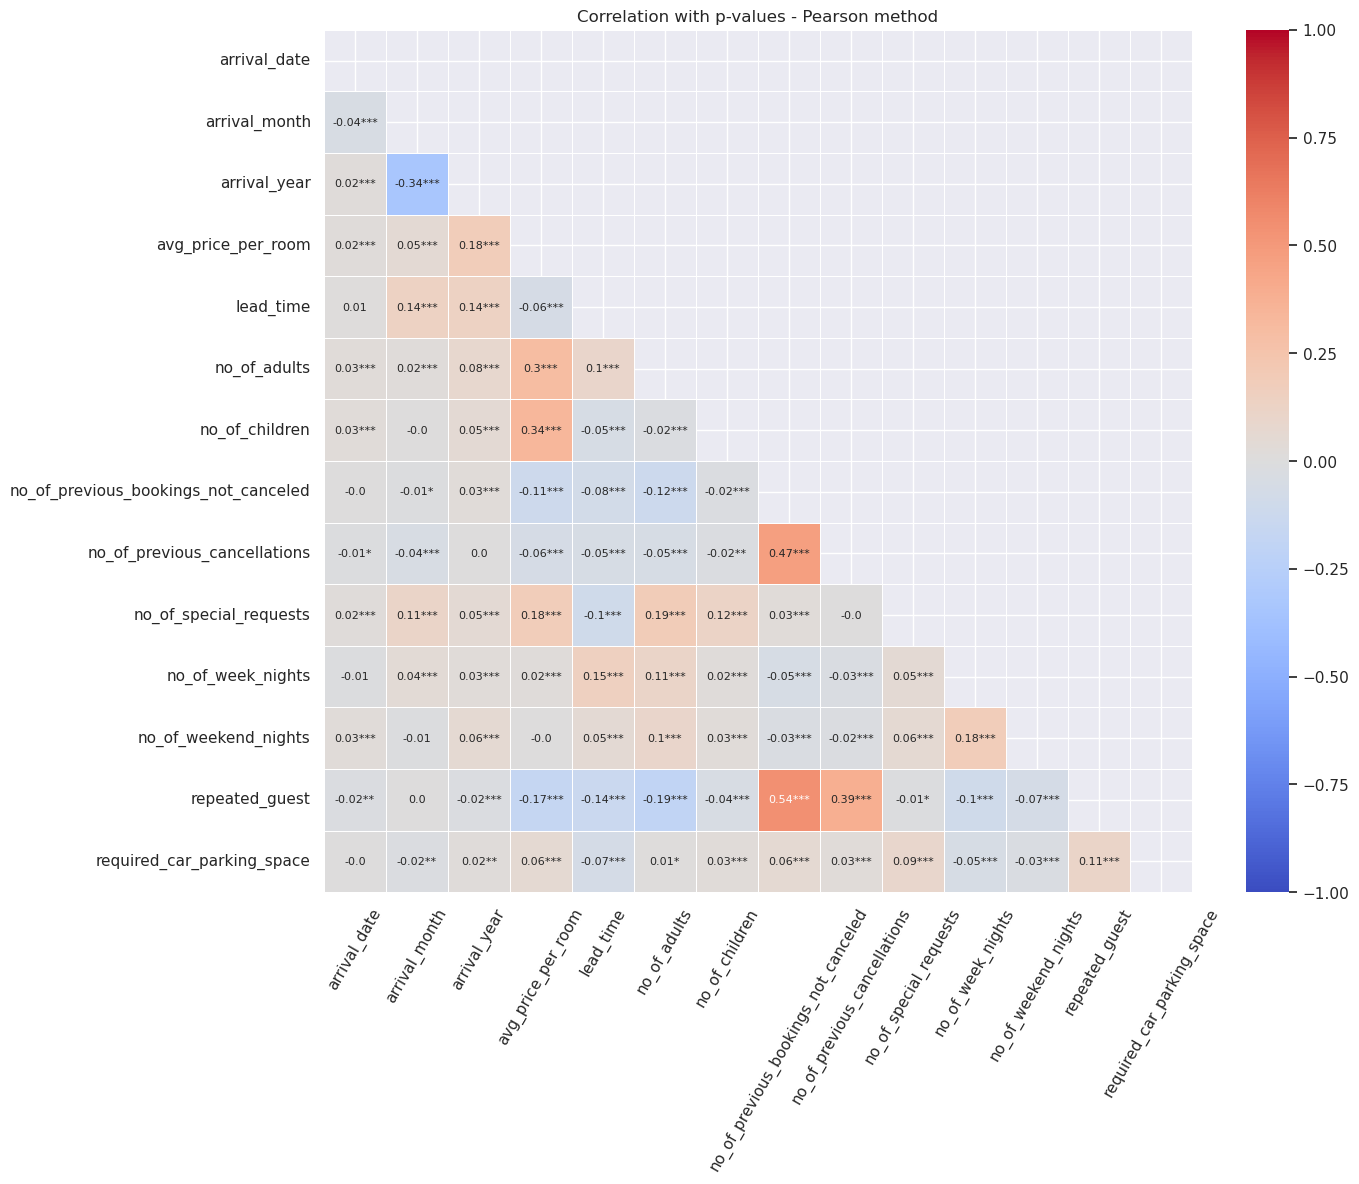

In [241]:
# Pearson correlation
corr_table = NonCategoricalFeatureEngineering.table_of_correlation_and_pvalues(df, method='pearson')
NonCategoricalFeatureEngineering.plot_correlation_heatmap(corr_table, method='Pearson', annotation=True)

# Note, this own library used has better style and have more information (represent p-value as *)
# The standard code is:
# plt.figure(figsize=(10,5))
# sns.heatmap(df.corr(method='pearson', numeric_only=True),annot=True, fmt=".1f")

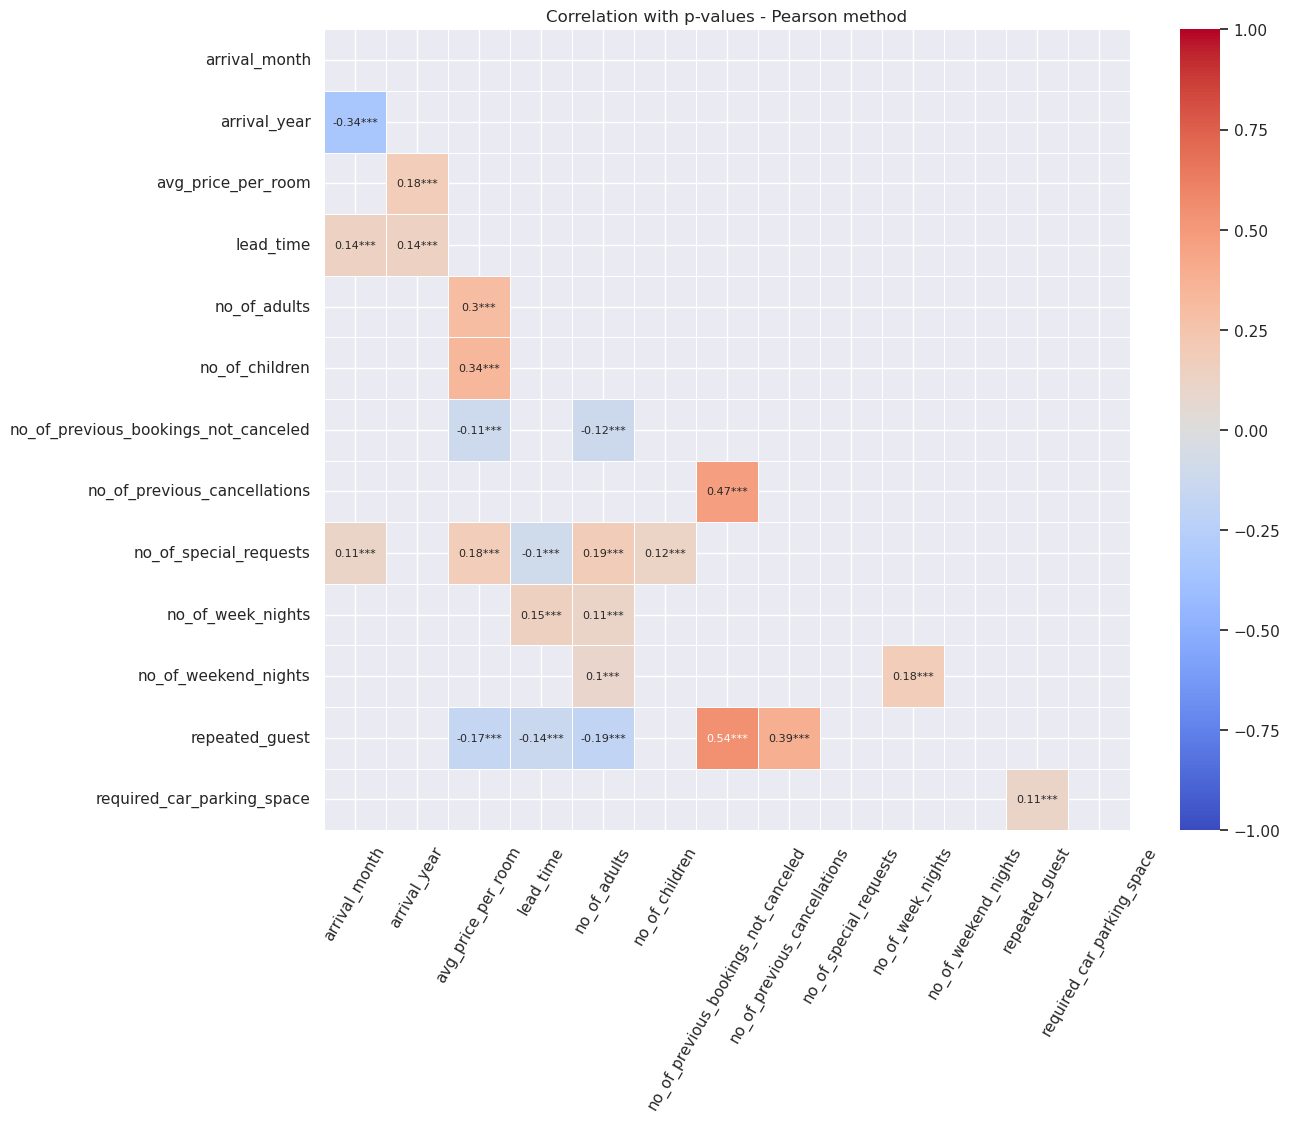

In [242]:
# We analyze correlations using Pearson's method, visualizing only those greater than 10% (correlation_limit=0.1) and with statistical significance.
# Filtered by correlation_limit=0.1, pvalue_limit=0.001

corr_table = NonCategoricalFeatureEngineering.table_of_correlation_and_pvalues(df, method='pearson')
corr_table_filtered, excluded_df = NonCategoricalFeatureEngineering.filter_corr_dataframe(corr_table,correlation_limit=0.1, pvalue_limit=0.001)
NonCategoricalFeatureEngineering.plot_correlation_heatmap(corr_table_filtered, method='Pearson', annotation=True)

In [243]:
excluded_df

,feature_1,feature_2,fails,p_value_discrepancy,correlation_discrepancy
0,no_of_adults,no_of_adults,p_value,NaN,NaN
1,no_of_adults,no_of_children,correlation,NaN,0.080213
4,no_of_adults,required_car_parking_space,both,0.028502,0.088571
5,no_of_adults,lead_time,correlation,NaN,0.002713
6,no_of_adults,arrival_year,correlation,NaN,0.023281
...,...,...,...,...,...
98,no_of_previous_cancellations,no_of_special_requests,both,0.526515,0.096683
99,no_of_previous_bookings_not_canceled,no_of_previous_bookings_not_canceled,p_value,NaN,NaN
101,no_of_previous_bookings_not_canceled,no_of_special_requests,correlation,NaN,0.072623
102,avg_price_per_room,avg_price_per_room,p_value,NaN,NaN


In [244]:
def summarize_exclusions(exclusions_df: pd.DataFrame) -> pd.DataFrame:
    # Flatten the feature pairs into a long format
    features_long = pd.melt(
        exclusions_df,
        id_vars=['fails', 'p_value_discrepancy', 'correlation_discrepancy'],
        value_vars=['feature_1', 'feature_2'],
        value_name='feature'
    )[["feature", "fails", "p_value_discrepancy", "correlation_discrepancy"]]
    
    # Aggregate stats
    summary = (
        features_long
        .groupby("feature")
        .agg(
            total_fails=("fails", "count"),
            both_fails=("fails", lambda x: (x == "both").sum()),
            corr_fails=("fails", lambda x: (x == "correlation").sum()),
            pval_fails=("fails", lambda x: (x == "p_value").sum()),
            mean_corr_discrepancy=("correlation_discrepancy", "mean"),
            mean_pval_discrepancy=("p_value_discrepancy", "mean"),
            max_corr_discrepancy=("correlation_discrepancy", "max"),
            max_pval_discrepancy=("p_value_discrepancy", "max"),
        )
        .sort_values("total_fails", ascending=False)
        .reset_index()
    )

    # Optional: rank features by combined discrepancy severity
    summary["severity_score"] = (
        summary["total_fails"] +
        summary["mean_corr_discrepancy"].fillna(0) * 10 +
        summary["mean_pval_discrepancy"].fillna(0) * 10
    )

    return summary.sort_values("severity_score", ascending=False)
    
summarize_exclusions(excluded_df)

,feature,total_fails,both_fails,corr_fails,pval_fails,mean_corr_discrepancy,mean_pval_discrepancy,max_corr_discrepancy,max_pval_discrepancy,severity_score
0,arrival_date,15,6,7,2,0.082861,0.346111,0.099963,0.993406,19.289720
1,required_car_parking_space,14,4,8,2,0.061385,0.256467,0.099963,0.993406,17.178521
4,no_of_children,13,2,9,2,0.072412,0.278880,0.096924,0.556962,16.512923
2,no_of_previous_cancellations,13,4,7,2,0.071896,0.249413,0.096683,0.526515,16.213085
5,arrival_month,12,5,5,2,0.076543,0.321012,0.099659,0.947207,15.975548
3,no_of_weekend_nights,13,2,9,2,0.065549,0.223181,0.095475,0.387837,15.887295
8,no_of_previous_bookings_not_canceled,11,2,7,2,0.066133,0.407298,0.098502,0.774376,15.734305
7,arrival_year,12,2,8,2,0.065301,0.228124,0.096081,0.454433,14.934255
11,avg_price_per_room,9,1,6,2,0.059023,0.387837,0.095475,0.387837,13.468602
10,no_of_special_requests,10,2,6,2,0.061428,0.274944,0.096683,0.526515,13.363719


Text(0.5, 1.0, 'Booking Distribution By The Days Of Months')

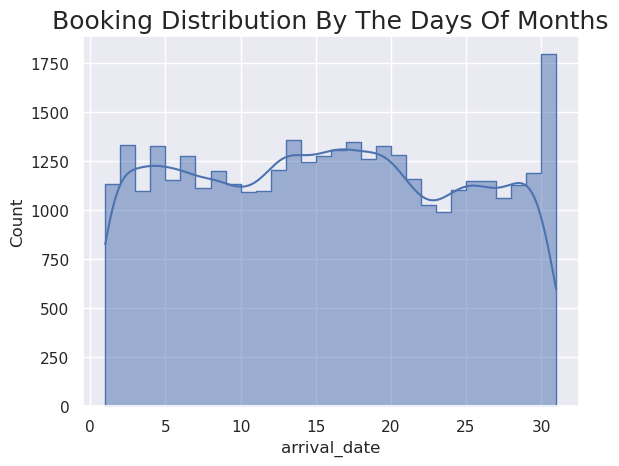

In [245]:
# A kernel density estimate (KDE) plot is a method for visualizing the distribution of observations in a dataset, analogous to a histogram. 
# KDE represents the data using a continuous probability density curve in one or more dimensions.
sns.histplot(data= df, x= "arrival_date", element="step", kde=True, bins=30)
plt.title("Booking Distribution By The Days Of Months",fontsize=18)

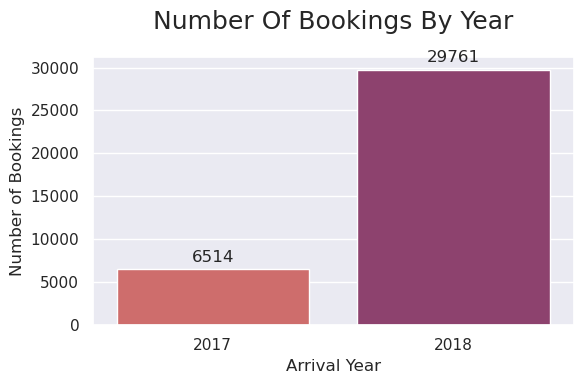

In [246]:
# Ensure arrival_year is numeric and handle potential missing values
df['arrival_year'] = pd.to_numeric(df['arrival_year'], errors='coerce')
df = df.dropna(subset=['arrival_year'])

# Create the countplot using seaborn
plt.figure(figsize=(6, 4))
ax = sns.countplot(data=df, x='arrival_year', palette='flare', order=sorted(df['arrival_year'].unique()))

# Add annotations using bar_label (cleaner approach)
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', padding=3, fontsize=12) # type: ignore

plt.title("Number Of Bookings By Year", fontsize=18, pad=20)
plt.xlabel("Arrival Year")
plt.ylabel("Number of Bookings")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

> Our samples are mostly from 2018

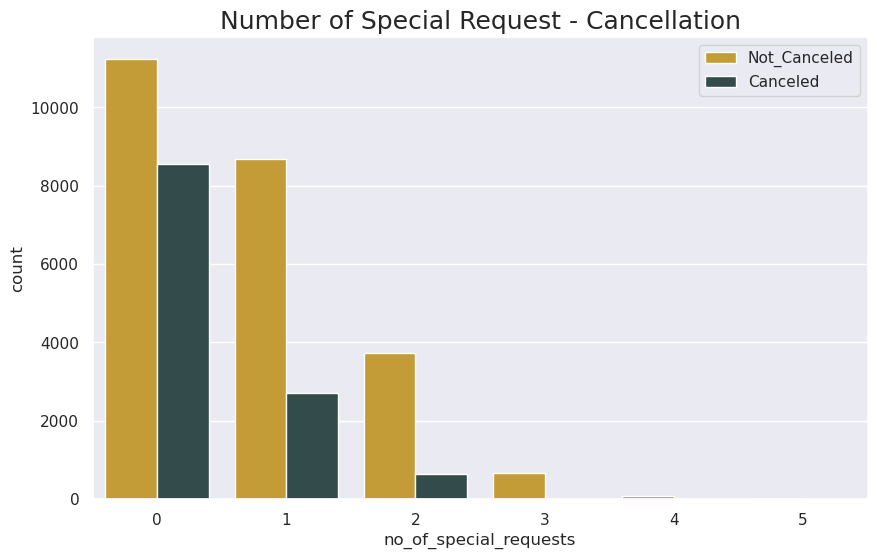

In [247]:
plt.figure(figsize=(10,6))
sns.countplot(x=df.no_of_special_requests, hue=df.booking_status,palette=sns.color_palette(["#daa520","#2f4f4f"]))
plt.title("Number of Special Request - Cancellation",fontsize=18);
plt.legend(loc="upper right")

> We can say that as the lead time increases the possibility of canceling increases
> The cancelation rate is higher for the guests who don't have a special request compare to others.

#### 🗒️ Insights for Non Categorical - without Target

`(required_car_parking_space)`
- **Modeling Insight** (*priority: low*): Weak positive correlation with repeated_guest (r=0.11); minimal multicollinearity concern.
- **Business Insight**: Slight association between requiring parking and being a repeat guest.

`(lead_time)`
- **Modeling Insight** (*priority: high*): Strong positive correlation with booking_status (r=0.44) and multiple other variables; key predictor requiring careful handling.
- **Business Insight**: Longer lead times strongly associated with higher cancellation rates.

`(arrival_year)`
- **Modeling Insight** (*priority: low*): Moderate correlations with arrival_month (r=0.19), avg_price_per_room (r=0.18), and booking_status (r=0.18).
- **Business Insight**: Year shows relationships with seasonal patterns, pricing, and cancellation behavior.

`(arrival_month)`
- **Modeling Insight** (*priority: medium*): Moderate correlation with avg_price_per_room (r=0.16); seasonal patterns may require encoding.
- **Business Insight**: Monthly variations relate to room pricing strategies.

`(arrival_date)`
- **Modeling Insight** (*priority: low*): Low correlations, we could drop the feature.
- **Business Insight**: TBD

`(repeated_guest)`
- **Modeling Insight** (*priority: high*): Multiple significant correlations including strong negative with no_of_people (r=-0.19) and positive with cancellations_rate (r=0.47).
- **Business Insight**: Repeat guests show different booking patterns and higher cancellation rates.

`(avg_price_per_room)`
- **Modeling Insight** (*priority: high*): Correlated with booking_status (r=0.14), no_of_people (r=0.29), and special_requests (r=0.18); may require scaling.
- **Business Insight**: Room pricing relates to group size, special requests, and cancellation likelihood.

`(no_of_special_requests)`
- **Modeling Insight** (*priority: medium*): Negative correlation with booking_status (r=-0.25); positive with no_of_people (r=0.19).
- **Business Insight**: More special requests associated with lower cancellations and larger groups.

`(no_of_people)`
- **Modeling Insight** (*priority: medium*): Correlated with repeated_guest (r=-0.19), avg_price_per_room (r=0.29), and week_days (r=0.11).
- **Business Insight**: Group size relates to pricing, repeat guest status, and stay duration.

`(no_of_week_days)`
- **Modeling Insight** (*priority: low*): Weak correlations with lead_time (r=0.15) and no_of_people (r=0.11).
- **Business Insight**: Stay duration shows minor relationships with booking timing and group size.

`(booking_status)`
- **Modeling Insight** (*priority: high*): Target variable with strong correlations to lead_time (r=0.44), arrival_year (r=0.18), and avg_price_per_room (r=0.14).
- **Business Insight**: Cancellation behavior driven by booking timing, seasonal factors, and pricing.

`(cancellations_rate)`
- **Modeling Insight** (*priority: high*): Very strong correlation with repeated_guest (r=0.47); potential multicollinearity concern.
- **Business Insight**: Repeat guests show significantly different cancellation patterns.

**Global Preprocessing Summary**
- **Transformations Recommended**: `(lead_time)`, `(avg_price_per_room)` (consider scaling due to correlation patterns)
- **Other Preprocessing Notes**: Monitor multicollinearity among `(repeated_guest)`, `(cancellations_rate)`, and `(booking_status)`; consider feature selection for highly correlated variables

**Non Categorical vs Target analysis**

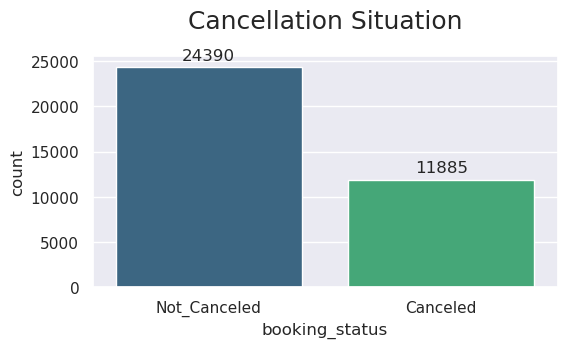

In [248]:
plt.figure(figsize=(6, 3))
ax = sns.countplot(data=df, x='booking_status', palette='viridis')

# Label ALL containers (bars)
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', padding=3, fontsize=12)  # type: ignore

plt.title("Cancellation Situation", fontsize=18, pad=20)
plt.subplots_adjust(top=0.88)
plt.show()

> Canceled and Not canceled classes were not distributed balanced so it may cause an imbalanced dataset problem. I will check it out.

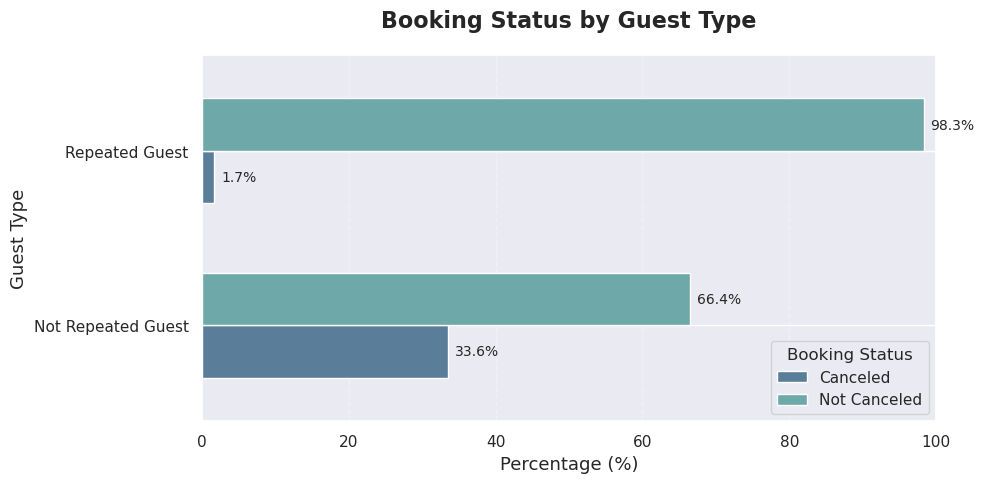

In [249]:
fig, ax = plt.subplots(figsize=(10, 5))

# First create the grouped data
grouped = (
    df.groupby('repeated_guest')['booking_status']
    .value_counts(normalize=True)
    .unstack()
    .fillna(0) * 100
)

# Then plot it
grouped.plot(
    kind='barh',
    color=['#5a7d9a', '#6fa8a8'],  # Viridis-inspired colors
    ax=ax,
    width=0.6
)

ax.set_title('Booking Status by Guest Type', fontsize=16, weight='bold', pad=20)
ax.set_xlabel('Percentage (%)', fontsize=13)
ax.set_ylabel('Guest Type', fontsize=13)
ax.legend(title='Booking Status', loc='lower right', fontsize=11, labels=['Canceled', 'Not Canceled'])
ax.set_yticklabels(['Not Repeated Guest', 'Repeated Guest'])
ax.set_xlim(0, 100)
ax.grid(axis='x', alpha=0.3, linestyle='--')

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', padding=5, fontsize=10)   # type: ignore

plt.tight_layout()
plt.show()

> The cancelation rate is higher for not repeated guest compare to repeated ones.
> Most of the repeated guest did not cancel their booking.

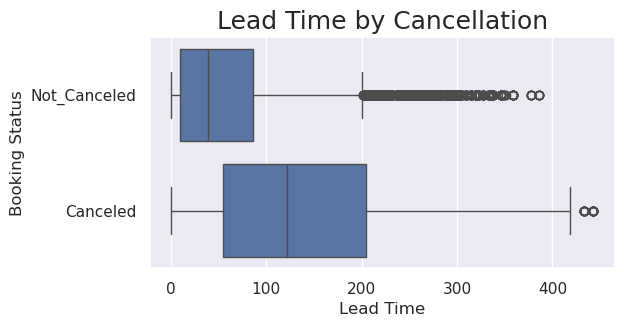

In [250]:

fig, ax = plt.subplots(figsize=(6, 3))
sns.boxplot(data=df, y="booking_status", x="lead_time")
plt.title("Lead Time by Cancellation", fontsize=18)
plt.xlabel("Lead Time", fontsize=12)
plt.ylabel("Booking Status", fontsize=12)
plt.show()

#### 🗒️ Insights for Non Categorical - with Target

`(booking_status)`
- **Modeling Insight** (*priority: high*): Significant class imbalance - Canceled (11,885) vs Not_Canceled (24,390); requires balancing techniques.
- **Business Insight**: The booking cancellation rate shows substantial business impact, with nearly one-third of bookings being canceled.

`(repeated_guest)`
- **Modeling Insight** (*priority: medium*): Categorical variable showing strong correlation with target; may require encoding and should be considered as important feature.
- **Business Insight**: Repeat guests have significantly lower cancellation rates (1.7%) compared to new guests (33.6%), indicating loyalty reduces cancellation risk.

`(lead_time)`
- **Modeling Insight** (*priority: high*): Numerical variable showing different distributions between canceled and non-canceled bookings; may require scaling/normalization and could be a strong predictor.
- **Business Insight**: Booking lead time appears to correlate with cancellation likelihood, suggesting that earlier bookings may have different cancellation patterns than last-minute bookings.

**Global Preprocessing Summary**
- **Transformations**: Recommended: `(lead_time)` (scaling/normalization due to wide range and predictive importance).
- **Target Imbalance**: `(booking_status)` — apply SMOTE, undersampling, or class-weight adjustment due to significant class imbalance.
- **Categorical Variables (One-Hot Encoding)**: `(repeated_guest)`.
- **Other Preprocessing Notes**: `(repeated_guest)` shows strong predictive power for the target variable and should be prioritized in feature selection.

#### 3.2. Between Categorical Variables

In [251]:
chi_square_analysis = CategoricalFeatureEngineering.chi_square_analysis(df=df, categorical_columns=categorical_columns) # ['type_of_meal_plan', 'market_segment_type']
chi_square_analysis

,variable_1,variable_2,chi2_statistic,p_value,degrees_of_freedom,sample_size,is_significant,min_expected_freq,cells_below_5,assumption_ok,recommendation,contingency_shape
0,type_of_meal_plan,room_type_reserved,2350.787808,0.000000e+00,18,36275,True,0.000965,9,False,DO NOT APPLY Cramer's V - Assumptions violated...,4x7
1,type_of_meal_plan,market_segment_type,5703.046688,0.000000e+00,12,36275,True,0.017229,5,False,DO NOT APPLY Cramer's V - Assumptions violated...,4x5
2,type_of_meal_plan,booking_status,278.294909,4.951915e-60,3,36275,True,1.638181,2,False,DO NOT APPLY Cramer's V - Assumptions violated...,4x2
3,room_type_reserved,market_segment_type,3950.438201,0.000000e+00,24,36275,True,0.024121,11,False,DO NOT APPLY Cramer's V - Assumptions violated...,7x5
4,room_type_reserved,booking_status,57.334952,1.562780e-10,6,36275,True,2.293453,2,True,APPLY Cramer's V - Significant association fou...,7x2
5,market_segment_type,booking_status,814.108865,6.748763e-175,4,36275,True,40.954514,0,True,APPLY Cramer's V - Significant association fou...,5x2


In [252]:
print(chi_square_analysis.recommendation.values)

["DO NOT APPLY Cramer's V - Assumptions violated. The significant p-value may be unreliable. Consider combining categories or using Fisher's Exact Test."
 "DO NOT APPLY Cramer's V - Assumptions violated. The significant p-value may be unreliable. Consider combining categories or using Fisher's Exact Test."
 "DO NOT APPLY Cramer's V - Assumptions violated. The significant p-value may be unreliable. Consider combining categories or using Fisher's Exact Test."
 "DO NOT APPLY Cramer's V - Assumptions violated. The significant p-value may be unreliable. Consider combining categories or using Fisher's Exact Test."
 "APPLY Cramer's V - Significant association found and test assumptions are met. Proceed to measure the strength of the association."
 "APPLY Cramer's V - Significant association found and test assumptions are met. Proceed to measure the strength of the association."]


In [253]:
recommended_pairs = CategoricalFeatureEngineering.get_recommended_pairs_for_cramers_v(chi_square_analysis)
print(recommended_pairs)

[('room_type_reserved', 'booking_status'), ('market_segment_type', 'booking_status')]


These are the only categorical features with significant association to make a Cramer´s V test:  
`['(room_type_reserved)','(market_sergment_type)','(booking_status)']`


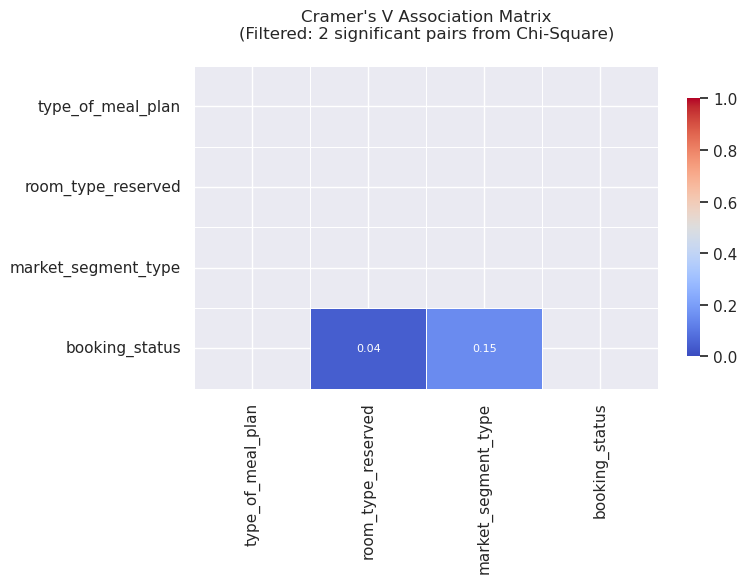

,type_of_meal_plan,room_type_reserved,market_segment_type,booking_status
type_of_meal_plan,NaN,NaN,NaN,NaN
room_type_reserved,NaN,1.000000,NaN,0.039756
market_segment_type,NaN,NaN,1.000000,0.149809
booking_status,NaN,0.039756,0.149809,1.000000


In [254]:
CategoricalFeatureEngineering.cramers_v_correlations(df=df, cat_vars=categorical_columns, relevant_chi_square_pairs= recommended_pairs)

#### 🗒️ Insights for Categorical

`(room_type_reserved)`
- **Modeling Insight** (*priority: medium*): Categorical variable with some significant association to target (Cramer's V: 0.15); check as predictive feature with other method.
- **Business Insight**: Different room types show varying cancellation patterns, suggesting room preference influences booking stability.

`(market_segment_type)`
- **Modeling Insight** (*priority: medium*): Categorical variable with significant association to target; requires encoding and contributes predictive power to the model.
- **Business Insight**: Booking channels or market segments exhibit different cancellation behaviors, indicating marketing source affects booking reliability.

`(type_of_meal_plan)`
- **Modeling Insight** (*priority: low*): Categorical variable with weak association to target (Cramer's V: 0.04); may have limited predictive value.
- **Business Insight**: Meal plan selection shows minimal correlation with cancellation behavior.

#### 3.3. Between Non-Categorical and Categorical Variables (Features Only)

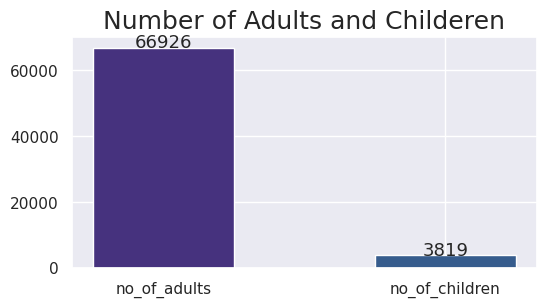

In [255]:
fig, ax = plt.subplots(figsize=(6,3))
ax.bar(np.arange(2),[df.no_of_adults.sum(),df.no_of_children.sum()],width=0.5, color=sns.color_palette("viridis"))
plt.xticks(np.arange(2),("no_of_adults","no_of_children"))

plt.title("Number of Adults and Childeren",fontsize=18);
for i, v in enumerate([df.no_of_adults.sum(),df.no_of_children.sum()]):
    ax.text(i, v + 0.5, str(v), ha='center',fontsize=13)

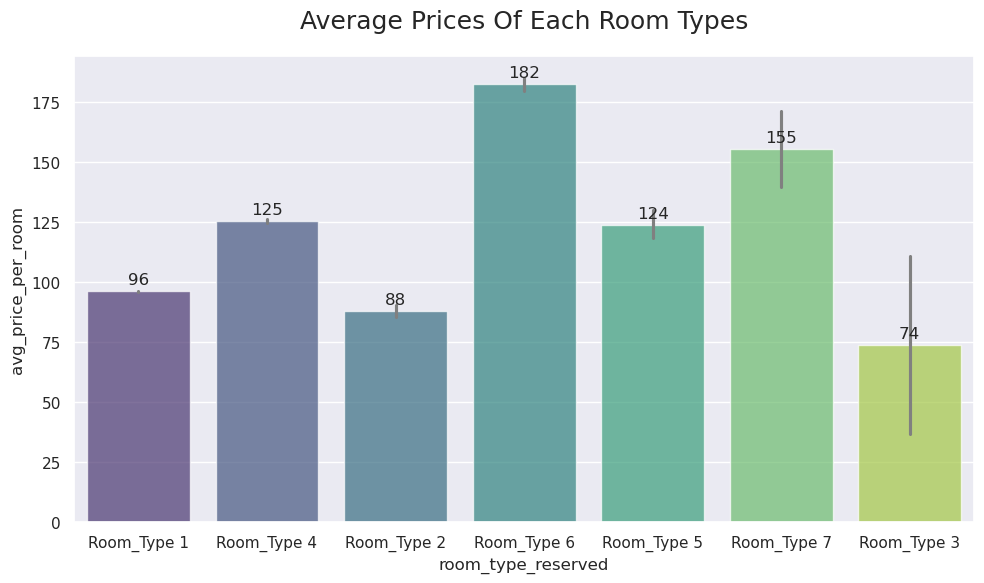

In [256]:
plt.figure(figsize=(10,6))

ax = sns.barplot(x=df.room_type_reserved, 
                 y=df.avg_price_per_room,
                 palette="viridis",
                 alpha=0.7,
                 #errorbar="ci", # Confidence Interval (sns uses Bootstrapping method)
                 errcolor="0.5")

plt.title("Average Prices Of Each Room Types", fontsize=18, pad=20)

# Improved annotation using bar_label
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', padding=3, fontsize=12) # type: ignore

plt.tight_layout()
plt.show()

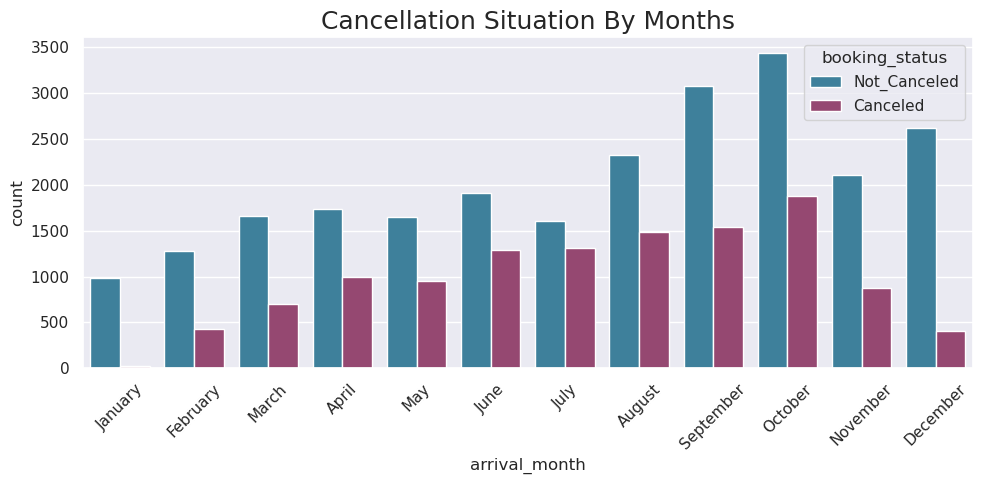

In [257]:
plt.figure(figsize=(10,5))
sns.countplot(x=df.arrival_month, hue=df.booking_status, 
              palette=["#2E86AB", "#A23B72"])  # Professional blue & burgundy
plt.xticks(np.arange(0,12), ["January","February","March","April","May","June",
                           "July","August","September","October","November","December"], 
           rotation=45)
plt.title("Cancellation Situation By Months", fontsize=18)
plt.tight_layout()
plt.show()

> Then, in feature ingineering, we will create from arrival_month a new binary feature acording monthly_rates of cancelation.

#### 🗒️ Insights Non-Categorical and Categorical Variables

`(no_of_adults)`
- **Modeling Insight** (*priority: medium*): Numerical count variable with wide range (1-6+ adults); may require scaling and outlier treatment for large group bookings.
- **Business Insight**: Number of adults in booking affects room configuration and pricing, potentially influencing cancellation decisions.

`(no_of_children)`
- **Modeling Insight** (*priority: medium*): Numerical count variable with many zero values; may require treatment for sparse distribution and potential encoding as categorical.
- **Business Insight**: Presence and number of children may indicate family travel patterns with different cancellation behaviors than adult-only bookings.

`(avg_price_per_room)`
- **Modeling Insight** (*priority: high*): Numerical variable showing significant price variation across room types (Range: ~25-175); requires scaling and may benefit from log transformation if skewed.
- **Business Insight**: Room pricing varies substantially by room type, with premium rooms costing significantly more, which may affect cancellation likelihood.

`(arrival_month)`
- **Modeling Insight** (*priority: high*): Categorical/ordinal variable showing seasonal cancellation patterns; **should be encoded** and used to create binary feature based on monthly cancellation rates.
- **Business Insight**: Booking cancellations show clear seasonal patterns across months, suggesting business cycles and seasonal demand affect booking stability.

## Feature Ingineering
- Selection of relevant features
- Creation of new features
- Dimensionality reduction (if applicable)

### Target Column = booking_status
* I will do encoding, take "Not_Canceled" as 0 and "Canceled" as 1.

In [258]:
df.booking_status = df.booking_status.replace({"Not_Canceled":0, "Canceled":1})

### "no_of_adults" and "no_of_children"
* I will use PCA method for these columns because they represent similar features and have close correlation. Instead of taking one of them i aim to benefit from both.

In [259]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
pca_no_people = pca.fit_transform(df[["no_of_adults","no_of_children"]])
df["no_of_people"] = pca_no_people

df.drop(columns=["no_of_adults","no_of_children"],inplace=True)

### "no_of_weekend_nights" and "no_of_week_nights"
* I will also use PCA for these columns because of the same reason too.

In [260]:
pca_no_week = pca.fit_transform(df[["no_of_weekend_nights","no_of_week_nights"]])
df["no_of_week_days"] = pca_no_week

df.drop(columns=["no_of_weekend_nights","no_of_week_nights"],inplace=True)

In [261]:
df.head()

,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,no_of_people,no_of_week_days
0,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,0,0.158982,-0.168923
1,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,0,0.158982,0.987358
2,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,1,-0.840274,-0.983180
3,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,1,0.158982,-0.339934
4,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,1,0.158982,-1.154192


### arrival_month
* According to the countplot of arrival_month i will categorize the months like this :
* The rate of those who do not cancel to those who cancel is higher and less than near 50% (was taken 40%)
* So The higher ones i will take them as 1, others are less these will be taken as 0.

In [262]:
# Get cancellation rates with month numbers as index
monthly_rates = (
    df.groupby('arrival_month')['booking_status']
    .value_counts()
    .unstack()
    .assign(cancellation_rate=lambda x: (x[1] / x[0] * 100))
    ['cancellation_rate']
)

monthly_rates

arrival_month
1      2.424242
2     33.751962
3     42.219542
4     57.151063
5     57.454545
6     67.520921
7     81.818182
8     64.000000
9     50.048812
10    54.698865
11    41.567696
12    15.349370
Name: cancellation_rate, dtype: float64

In [263]:
monthly_rates[monthly_rates > 40]

arrival_month
3     42.219542
4     57.151063
5     57.454545
6     67.520921
7     81.818182
8     64.000000
9     50.048812
10    54.698865
11    41.567696
Name: cancellation_rate, dtype: float64

* The higher ones are 3,4,5,6,7,9 and i will take them as 1
* Others are less these will be taken as 0

In [264]:
df.arrival_month = df.arrival_month.replace({3:1, 4:1, 5:1, 6:1, 7:1, 9:1, 1:0, 2:0, 8:0, 10:0, 11:0, 12:0})

### "no_of_previous_cancellations" and "no_of_previous_bookings_not_canceled"
* I will calculate the rate of cancellations as a percentage and keep them as a new column which is called "cancellations_rate" and delete these two columns.

In [265]:
df["cancellations_rate"] = df["no_of_previous_cancellations"] / (df["no_of_previous_cancellations"] + df["no_of_previous_bookings_not_canceled"]) *100
df.cancellations_rate.fillna(0,inplace=True)

In [266]:
df.drop(columns=["no_of_previous_cancellations","no_of_previous_bookings_not_canceled"],inplace=True)

In [267]:
df.head()

,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,avg_price_per_room,no_of_special_requests,booking_status,no_of_people,no_of_week_days,cancellations_rate
0,Meal Plan 1,0,Room_Type 1,224,2017,0,2,Offline,0,65.00,0,0,0.158982,-0.168923,0.0
1,Not Selected,0,Room_Type 1,5,2018,0,6,Online,0,106.68,1,0,0.158982,0.987358,0.0
2,Meal Plan 1,0,Room_Type 1,1,2018,0,28,Online,0,60.00,0,1,-0.840274,-0.983180,0.0
3,Meal Plan 1,0,Room_Type 1,211,2018,1,20,Online,0,100.00,0,1,0.158982,-0.339934,0.0
4,Not Selected,0,Room_Type 1,48,2018,1,11,Online,0,94.50,0,1,0.158982,-1.154192,0.0


## Feature Importance Analysis

In [268]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

def random_forest_importance_analysis(df, target, importance_threshold=0.02, top_n=10, 
                           random_state=8818, plot_results=True, figsize=(16, 12)):
    """
    Analyzes feature importance using Random Forest (Gini importance)
    Automatically handles categorical variables with encoding
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Complete DataFrame with features and target
    target : str
        Name of the target column
    importance_threshold : float, default=0.02 (2% of total importance)
        Minimum importance score to consider a feature as important.
        Features with importance >= threshold are classified as important,
        while features below are considered unimportant and potential candidates for removal.
    top_n : int, default=10
        Number of top features to display in plots
    random_state : int, default=42
        Seed for reproducibility
    plot_results : bool, default=True
        Whether to generate results plots
    figsize : tuple, default=(16, 12)
        Figure size for plots (width, height) in inches
    
    Returns:
    --------
    pandas.DataFrame : Comprehensive DataFrame with feature importance analysis
    
    Note on Data Distributions:
    ---------------------------
    Random Forest is robust to long-tailed distributions and outliers due to its 
    tree-based nature. No logarithmic transformations are typically needed for 
    skewed features, as the algorithm handles different data scales effectively 
    through binary splitting. The importance scores remain reliable across 
    various data distributions.
    
    Scoring Method Explanation:
    ---------------------------
    The feature importance scores are calculated using Gini Importance (Mean Decrease in Impurity).
    For each feature, the algorithm measures how much each feature decreases the weighted impurity 
    (Gini index) in the Random Forest trees. Features that result in higher decrease in impurity 
    across all trees are considered more important.
    
    Mathematically, for each tree:
    Importance = (Weighted impurity decrease) = 
                 (Node probability * Impurity decrease) for all splits using the feature
                 
    The final importance is normalized so that all importances sum to 1.
    """
    
    # 1. Prepare data
    X = df.drop(columns=[target])
    y = df[target]
    
    # 2. Identify and encode categorical variables
    X_encoded = X.copy()
    categorical_columns = X_encoded.select_dtypes(include=['object', 'category']).columns
    numeric_columns = X_encoded.select_dtypes(include=[np.number]).columns
    
    label_encoders = {}
    
    if len(categorical_columns) > 0:
        for col in categorical_columns:
            le = LabelEncoder()
            X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
            label_encoders[col] = le
    
    # 3. Train model and calculate feature importance
    model = RandomForestClassifier(
        n_estimators=100, 
        random_state=random_state
    )
    model.fit(X_encoded, y)
    
    # 4. Create comprehensive results DataFrame
    importance_results = pd.DataFrame({
        'feature': X_encoded.columns,
        'importance_score': model.feature_importances_,
        'feature_type': ['categorical' if col in categorical_columns else 'numeric' 
                        for col in X_encoded.columns]
    })
    
    # Sort by importance for ranking and cumulative calculation
    importance_results = importance_results.sort_values('importance_score', ascending=False)
    importance_results['rank'] = range(1, len(importance_results) + 1)
    
    # 5. Calculate cumulative importance correctly
    # First sort by importance (descending) for cumulative sum
    importance_sorted = importance_results.sort_values('importance_score', ascending=False)
    importance_sorted['cumulative_importance'] = importance_sorted['importance_score'].cumsum()
    importance_sorted['cumulative_percentage'] = importance_sorted['cumulative_importance'] * 100
    
    # Calculate individual percentage
    total_importance = importance_sorted['importance_score'].sum()
    importance_sorted['importance_percentage'] = (importance_sorted['importance_score'] / total_importance) * 100
    
    # Add importance category
    importance_sorted['importance_category'] = ['important' if score >= importance_threshold else 'unimportant'
                                               for score in importance_sorted['importance_score']]
    
    importance_results = importance_sorted.reset_index(drop=True)
    
    # 6. Classify features by importance
    important_features = importance_results[importance_results['importance_score'] >= importance_threshold]
    unimportant_features = importance_results[importance_results['importance_score'] < importance_threshold]
    
    # 7. Generate plots if requested
    if plot_results:
        # Create 2x2 grid for better layout
        fig = plt.figure(figsize=figsize)
        
        # Plot 1: Top N features (top-left)
        ax1 = plt.subplot(2, 2, 1)
        top_features = importance_results.head(top_n)
        colors = ['steelblue' if ft == 'numeric' else 'indianred' for ft in top_features['feature_type']]
        bars = ax1.barh(range(len(top_features)), top_features['importance_score'], color=colors)
        ax1.set_yticks(range(len(top_features)))
        ax1.set_yticklabels(top_features['feature'])
        ax1.set_xlabel('Feature Importance Score')
        ax1.set_title(f'Top {top_n} Features by Importance')
        ax1.grid(axis='x', alpha=0.3)
        
        # Add legend for feature types
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='steelblue', label='Numeric Features'),
            Patch(facecolor='indianred', label='Categorical Features')
        ]
        ax1.legend(handles=legend_elements, loc='lower right')
        
        # Plot 2: Distribution by threshold (top-right)
        ax2 = plt.subplot(2, 2, 2)
        thresholds = ['Important', 'Unimportant']
        counts = [len(important_features), len(unimportant_features)]
        colors_threshold = ['lightgreen', 'lightcoral']
        ax2.pie(counts, labels=thresholds, autopct='%1.1f%%', 
                colors=colors_threshold, startangle=90)
        ax2.set_title(f'Feature Distribution\n(Importance threshold = {importance_threshold})')
        
        # Plot 3: Cumulative importance (bottom - spans both columns)
        ax3 = plt.subplot(2, 1, 2)
        ax3.plot(range(1, len(importance_results) + 1), 
                importance_results['cumulative_percentage'], 
                marker='o', linewidth=2, markersize=4, color='purple')
        ax3.axhline(y=80, color='red', linestyle='--', alpha=0.7, label='80% Importance')
        ax3.axhline(y=90, color='orange', linestyle='--', alpha=0.7, label='90% Importance')
        ax3.set_xlabel('Number of Features')
        ax3.set_ylabel('Cumulative Importance (%)')
        ax3.set_title('Cumulative Feature Importance')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # Add some annotations to the cumulative plot
        if len(importance_results) >= 5:
            ax3.annotate(f'Top 5: {importance_results.iloc[4]["cumulative_percentage"]:.1f}%', 
                        xy=(5, importance_results.iloc[4]["cumulative_percentage"]),
                        xytext=(10, 10), textcoords='offset points',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
        
        if len(importance_results) >= 10:
            ax3.annotate(f'Top 10: {importance_results.iloc[9]["cumulative_percentage"]:.1f}%', 
                        xy=(10, importance_results.iloc[9]["cumulative_percentage"]),
                        xytext=(10, 10), textcoords='offset points',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.7))
        
        plt.tight_layout()
        plt.show()
    
    # 8. Return the comprehensive DataFrame
    return importance_results

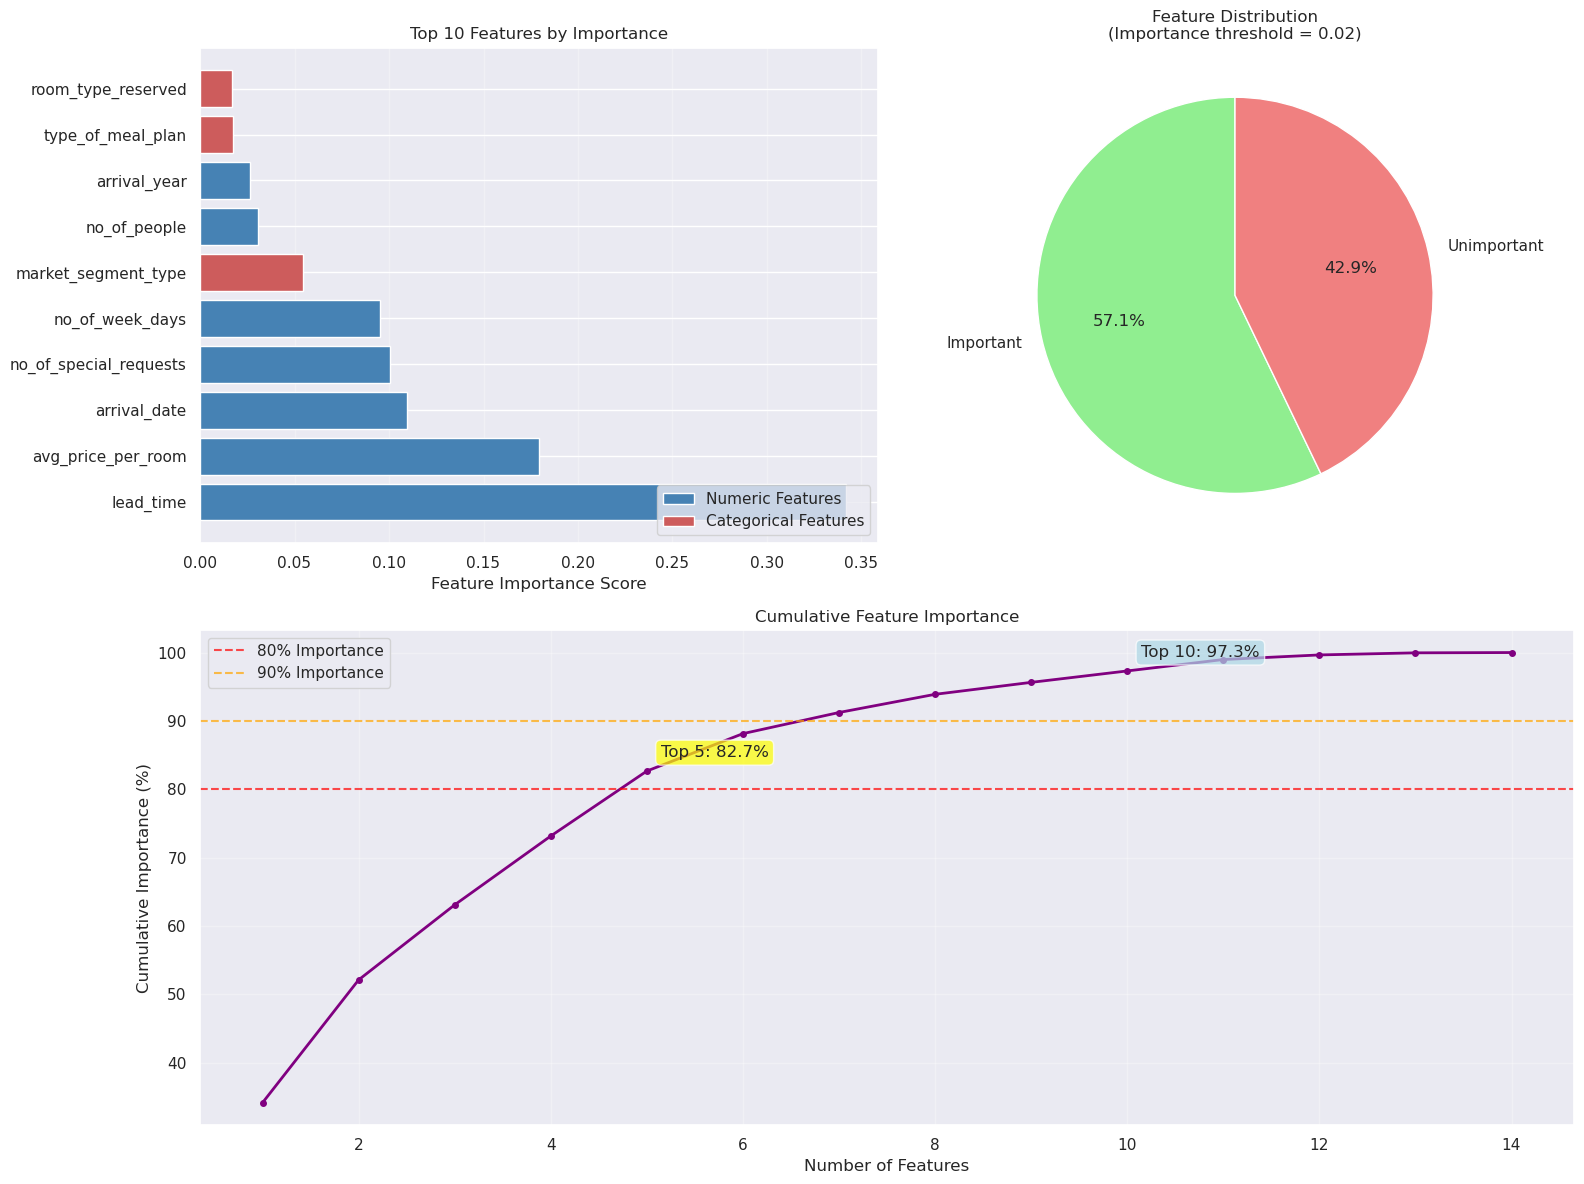

In [269]:
results_importance_analysis = random_forest_importance_analysis(
    df=df,
    target='booking_status',
    importance_threshold=0.02,
    top_n=10,
    plot_results=True,
)

In [270]:
results_importance_analysis

,feature,importance_score,feature_type,rank,cumulative_importance,cumulative_percentage,importance_percentage,importance_category
0,lead_time,0.341700,numeric,1,0.341700,34.169979,34.169979,important
1,avg_price_per_room,0.179622,numeric,2,0.521321,52.132140,17.962160,important
2,arrival_date,0.109753,numeric,3,0.631074,63.107426,10.975286,important
3,no_of_special_requests,0.100617,numeric,4,0.731691,73.169118,10.061692,important
4,no_of_week_days,0.095019,numeric,5,0.826710,82.670982,9.501864,important
5,market_segment_type,0.054713,categorical,6,0.881423,88.142267,5.471285,important
6,no_of_people,0.030897,numeric,7,0.912319,91.231918,3.089651,important
7,arrival_year,0.026598,numeric,8,0.938917,93.891716,2.659798,important
8,type_of_meal_plan,0.017472,categorical,9,0.956389,95.638922,1.747206,unimportant
9,room_type_reserved,0.016708,categorical,10,0.973097,97.309688,1.670765,unimportant


In [271]:
less_important_features = results_importance_analysis[results_importance_analysis['importance_category']=='unimportant'].sort_values(by='importance_score', ascending=False)
less_important_features['feature'].to_list()

['type_of_meal_plan',
 'room_type_reserved',
 'arrival_month',
 'required_car_parking_space',
 'repeated_guest',
 'cancellations_rate']

>**Note:**  
From *#### 🗒️ Insights for Non-Categorical Variables (Univariate)*, we identified a long-tailed distributions.
I applied the transformations and repeated the importance analysis, but the result remained the same. This is because Random Forest method is not affected by skewed features.

## Feature Selection

Taking in EDA analysis the **#### 🗒️ Insights for Non Categorical - without Target**  and **## Feature Importance Analysis** conclutions we can drop:

`(arrival_date)`
- **Modeling Insight** (*priority: low*): Very low correlation with the target; recommended to remove.
- **Business Insight**: no relevant information.

`(arrival_year)`
- **Modeling Insight** (*priority: low*): Contains only two years (2017, 2018); may not generalize to future predictions due to potential event-specific biases.
- **Business Insight**: The limited timeframe may not be representative of future booking patterns, as specific events (e.g., a pandemic) could have skewed the results.

`(room_type_reserved)`
- **Modeling Insight** (*priority: low*): Recommended to remove due low importance (on ### 4. Feature Importance Analysis). It had some significant association to target (Cramer's V: 0.15) (on #### 🗒️ Insights for Categorical) but is not enough.
- **Business Insight**: The type of room reserved is likely reflected in the average price per room, making the price a more direct indicator.

`(cancellations_rate)`
- **Modeling Insight** (*priority: low*): Low correlation with the target; recommended to remove.
- **Business Insight**: no relevant information.

- 'type_of_meal_plan' (keep for now)
- 'room_type_reserved' (*drop*)
- 'arrival_month'  (*new drop*)
- 'required_car_parking_space'  (*new drop*)
- 'repeated_guest' (*drop*)
- 'cancellations_rate (*drop*)


In [272]:
df.drop(columns=["room_type_reserved","arrival_year",
                 "arrival_date","cancellations_rate", "arrival_month", "required_car_parking_space"],inplace=True)

## Scaling
* I will scale the numerical features

In [273]:
# Update column lists
categorical_columns, non_categorical_columns = GeneralFeatureEngineering.detect_categorical_and_non_categorical_columns(df)

Categorical Columns:     ['type_of_meal_plan', 'market_segment_type']
Non-Categorical Columns: ['lead_time', 'repeated_guest', 'avg_price_per_room', 'no_of_special_requests', 'booking_status', 'no_of_people', 'no_of_week_days']


In [274]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

df[non_categorical_columns] = scaler.fit_transform(df[non_categorical_columns])

In [275]:
df

,type_of_meal_plan,lead_time,market_segment_type,repeated_guest,avg_price_per_room,no_of_special_requests,booking_status,no_of_people,no_of_week_days
0,Meal Plan 1,1.532110,Offline,0.0,-0.867758,0.0,0.0,0.000000,0.000000
1,Not Selected,-0.477064,Online,0.0,0.182116,1.0,0.0,0.000000,0.642547
2,Meal Plan 1,-0.513761,Online,0.0,-0.993703,0.0,1.0,-25.914924,-0.452484
3,Meal Plan 1,1.412844,Online,0.0,0.013854,0.0,1.0,0.000000,-0.095031
4,Not Selected,-0.082569,Online,0.0,-0.124685,0.0,1.0,0.000000,-0.547516
...,...,...,...,...,...,...,...,...,...
36270,Meal Plan 1,0.256881,Online,0.0,1.721662,1.0,0.0,25.914924,2.285094
36271,Meal Plan 1,1.568807,Online,0.0,-0.214106,2.0,1.0,0.000000,0.547516
36272,Meal Plan 1,0.834862,Online,0.0,-0.026700,2.0,0.0,0.000000,2.285094
36273,Not Selected,0.055046,Online,0.0,-0.124685,0.0,1.0,0.000000,0.452484


## Categorical Encoding

In [276]:
df.type_of_meal_plan.value_counts()
# Then of encoding drop Meal Plan 3 column

type_of_meal_plan
Meal Plan 1     27835
Not Selected     5130
Meal Plan 2      3305
Meal Plan 3         5
Name: count, dtype: int64

In [277]:
df.market_segment_type.value_counts()
# Then of encoding drop Complementary and Aviation

market_segment_type
Online           23214
Offline          10528
Corporate         2017
Complementary      391
Aviation           125
Name: count, dtype: int64

In [278]:
df = pd.get_dummies(df,columns=["type_of_meal_plan","market_segment_type"])
df.head(3).columns.to_list()

['lead_time',
 'repeated_guest',
 'avg_price_per_room',
 'no_of_special_requests',
 'booking_status',
 'no_of_people',
 'no_of_week_days',
 'type_of_meal_plan_Meal Plan 1',
 'type_of_meal_plan_Meal Plan 2',
 'type_of_meal_plan_Meal Plan 3',
 'type_of_meal_plan_Not Selected',
 'market_segment_type_Aviation',
 'market_segment_type_Complementary',
 'market_segment_type_Corporate',
 'market_segment_type_Offline',
 'market_segment_type_Online']

> I will repeate the importance analysis to check the new summy columns

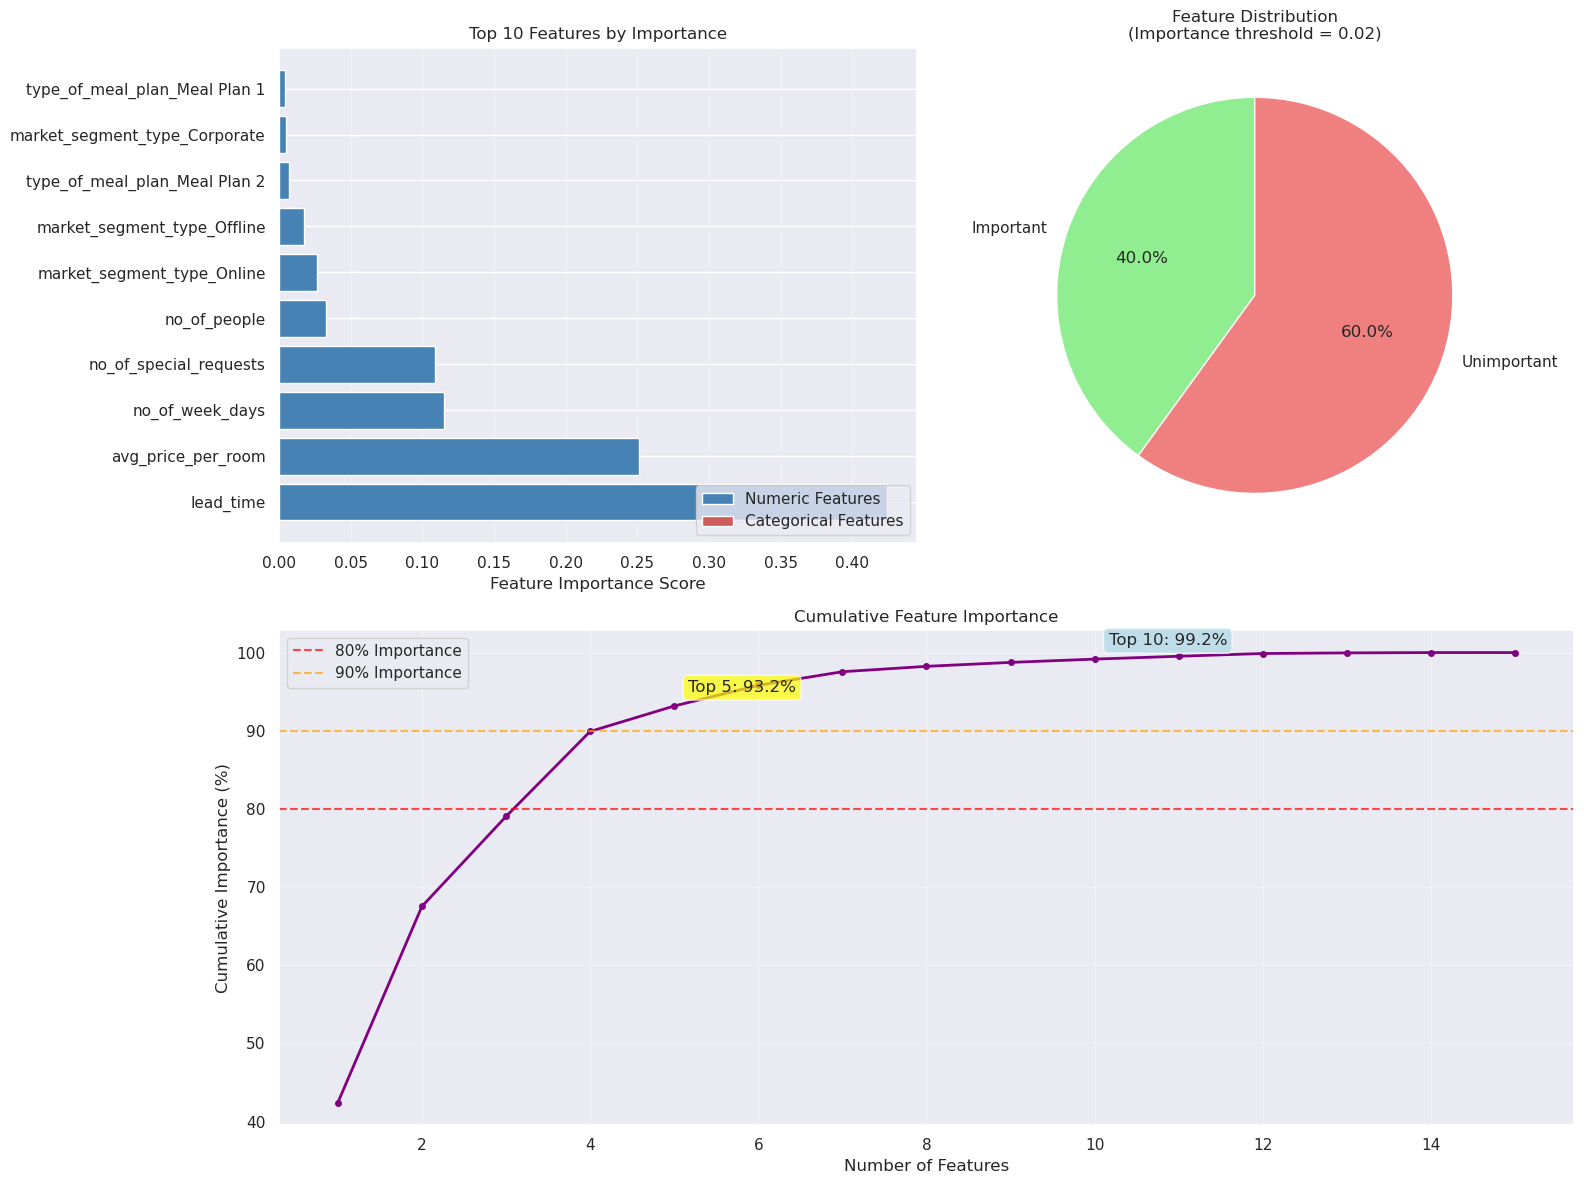

In [279]:
results_importance_analysis = random_forest_importance_analysis(
    df=df,
    target='booking_status',
    importance_threshold=0.02,
    top_n=10,
    plot_results=True,
)

In [280]:
results_importance_analysis

,feature,importance_score,feature_type,rank,cumulative_importance,cumulative_percentage,importance_percentage,importance_category
0,lead_time,0.424229,numeric,1,0.424229,42.422924,42.422924,important
1,avg_price_per_room,0.251076,numeric,2,0.675305,67.530481,25.107557,important
2,no_of_week_days,0.115043,numeric,3,0.790348,79.034765,11.504284,important
3,no_of_special_requests,0.108715,numeric,4,0.899062,89.906239,10.871474,important
4,no_of_people,0.032553,numeric,5,0.931615,93.161509,3.255270,important
5,market_segment_type_Online,0.026471,numeric,6,0.958086,95.808561,2.647052,important
6,market_segment_type_Offline,0.017383,numeric,7,0.975469,97.546863,1.738302,unimportant
7,type_of_meal_plan_Meal Plan 2,0.006891,numeric,8,0.982360,98.235992,0.689130,unimportant
8,market_segment_type_Corporate,0.005032,numeric,9,0.987392,98.739150,0.503158,unimportant
9,type_of_meal_plan_Meal Plan 1,0.004208,numeric,10,0.991599,99.159905,0.420754,unimportant


In [281]:
less_important_features = results_importance_analysis[results_importance_analysis['importance_category']=='unimportant'].sort_values(by='importance_score', ascending=False)
less_important_features['feature'].to_list()

['market_segment_type_Offline',
 'type_of_meal_plan_Meal Plan 2',
 'market_segment_type_Corporate',
 'type_of_meal_plan_Meal Plan 1',
 'type_of_meal_plan_Not Selected',
 'repeated_guest',
 'market_segment_type_Complementary',
 'market_segment_type_Aviation',
 'type_of_meal_plan_Meal Plan 3']

> I will drop some columns that have less samples and bad correlation with the target
  
- 'market_segment_type_Offline' (*drop by unbalance distribution*)
- 'type_of_meal_plan_Meal Plan 2'
- 'market_segment_type_Corporate'
- 'type_of_meal_plan_Meal Plan 1'
- 'type_of_meal_plan_Not Selected' (*drop by unbalance distribution*)
- 'repeated_guest'
- 'market_segment_type_Complementary' (*drop by poor correlation*)
- 'market_segment_type_Aviation' (*drop by poor correlation*)
- 'type_of_meal_plan_Meal Plan 3' (*drop by poor correlation*)

In [282]:
df.drop(columns=['type_of_meal_plan_Meal Plan 3','type_of_meal_plan_Not Selected',
                 'market_segment_type_Aviation',"market_segment_type_Complementary","market_segment_type_Offline"],inplace=True)

## Determine x and y

In [283]:
x = df.drop(columns="booking_status")
y = df.booking_status

## Train-Test Split

In [316]:
#TODO Move Train-Test Split abefore scaling (## Scaling) to avoid posible data leakage

In [284]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(x,y, test_size=0.2, random_state=42)
print("Train_x :",train_x.shape)
print("Test_x :",test_x.shape)
print("Train_y :",train_y.shape)
print("Test_y :",test_y.shape)

Train_x : (29020, 10)
Test_x : (7255, 10)
Train_y : (29020,)
Test_y : (7255,)


## Modeling With Random Forest Classifier

In [310]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(train_x, train_y)
print("Accuracy of Random Forest : % {}".format(rf.score(test_x,test_y)*100))

Accuracy of Random Forest : % 88.55961405926946


In [311]:
from sklearn.metrics import classification_report
y_pred = rf.predict(test_x)
print(classification_report(test_y, y_pred))

              precision    recall  f1-score   support

         0.0       0.90      0.93      0.92      4839
         1.0       0.85      0.79      0.82      2416

    accuracy                           0.89      7255
   macro avg       0.88      0.86      0.87      7255
weighted avg       0.88      0.89      0.88      7255



* **Precision: Percentage of correct positive predictions relative to total positive predictions.**
    When we predict True, how often is it really True? This number should be as high as possible. \
     High precision: Not many True values were predicted as False
$$precision = \frac{TP}{TP+FP}$$
    *TP: true positive* \
    *FN: false negative*
    

* **Recall: Percentage of correct positive predictions relative to total actual positives.**
    The recall, also named sensivity, or hit rate, tells us the fraction of correctly identified positive predictions.
    What fraction of the True predictions were actually True? This number should be as high as possible. \
    High recall: Predicted most True values correctly.
$$recall = \frac{TP}{TP+FN}$$


* **F1 Score: A weighted harmonic mean of precision and recall. The closer to 1, the better the model.**
    The f1-score, or F measure, measures precision and recall at the same time by finding the harmonic mean of the two values. \
    This score is useful when you have opposite scores coming from precision and recall.

$$f1-Score = \frac{2*Precision * Recall}{Precision + Recall}$$


* **Support: The support is the number of occurrences of each class in your y_test.**

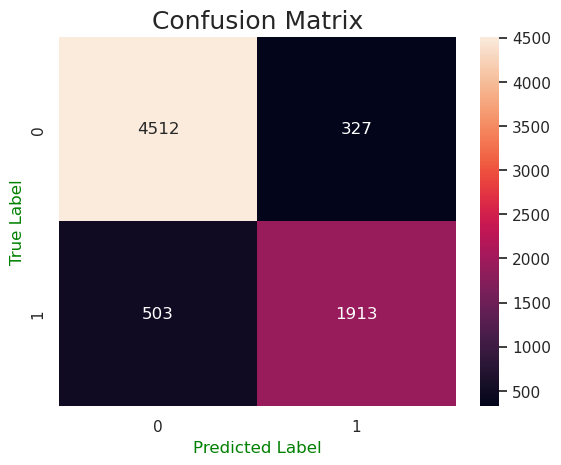

In [312]:
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(test_y,rf.predict(test_x)), annot=True, fmt=".0f")
plt.title("Confusion Matrix", fontsize=18)
plt.xlabel("Predicted Label", color = "green", fontsize = 12)
plt.ylabel("True Label", color = "green", fontsize = 12);

In [ ]:
y_pred = rf.predict(test_x)
accuracy_0 = confusion_matrix(test_y, y_pred)[0][0] / (confusion_matrix(test_y, y_pred)[0][0] + confusion_matrix(test_y, y_pred)[0][1])
accuracy_1 = confusion_matrix(test_y, y_pred)[1][1] / (confusion_matrix(test_y, y_pred)[1][0] + confusion_matrix(test_y, y_pred)[1][1])

print("Accuracy of Not Cancelled :",accuracy_0)
print("Accuracy of Cancelled :", accuracy_1)

Accuracy of Not Cancelled : 0.9324240545567266
Accuracy of Cancelled : 0.7918046357615894


### Inferences
* As we see we have good accuracy.
* But when we check the other metrics we see that even though we predict not cancelled class so good (specificity) , we are not so good at predicting cancelled class (sensitivity).
* This is based on imbalanced dataset as i mentioned i think we need to get rid of this problem.
* First i will use undersampling method after that i will use oversampling.
* Finally i will compare the results.

## Under-Sampling
* Under-sampling is a technique to balance uneven datasets by keeping all of the data in the minority class and decreasing the size of the majority class.
* NOTE : We should use sampling methods only upon the train dataset otherwise it would be inacurate.

In [289]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
train_x_undersampled,train_y_undersampled = rus.fit_resample(train_x,train_y)

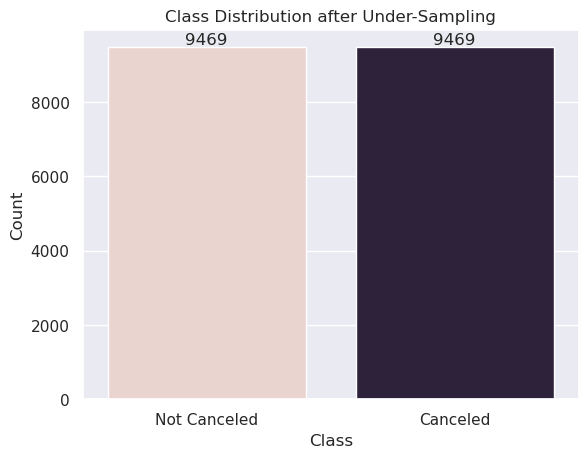

In [314]:
ax = sns.countplot(x=train_y_undersampled, palette=sns.cubehelix_palette(2))

# Añadir etiquetas encima de las barras
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12)

plt.xticks([0, 1], ['Not Canceled', 'Canceled'])
plt.title("Class Distribution after Under-Sampling")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


## Modeling After Under-Sampling

### Random Forest

In [291]:
rf_sampled = RandomForestClassifier(n_estimators=110,random_state=42)
rf_sampled.fit(train_x_undersampled, train_y_undersampled)
print("Accuracy of Random Forest : % {}".format(rf_sampled.score(test_x,test_y)*100))

Accuracy of Random Forest : % 86.11991729841489


In [292]:
print(classification_report(test_y,rf_sampled.predict(test_x)))

              precision    recall  f1-score   support

         0.0       0.92      0.87      0.89      4839
         1.0       0.76      0.85      0.80      2416

    accuracy                           0.86      7255
   macro avg       0.84      0.86      0.85      7255
weighted avg       0.87      0.86      0.86      7255



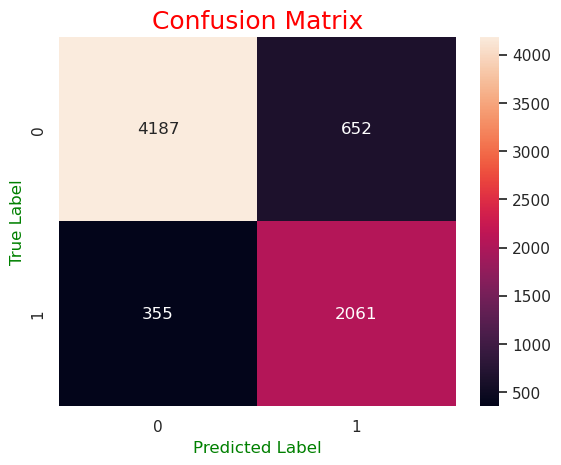

In [293]:
sns.heatmap(confusion_matrix(test_y,rf_sampled.predict(test_x)), annot=True, fmt=".0f")
plt.title("Confusion Matrix", color = "red", fontsize=18)
plt.xlabel("Predicted Label", color = "green", fontsize = 12)
plt.ylabel("True Label", color = "green", fontsize = 12);

In [ ]:
accuracy_0 = confusion_matrix(test_y,rf_sampled.predict(test_x))[0][0] / (confusion_matrix(test_y,rf_sampled.predict(test_x))[0][0] + confusion_matrix(test_y,rf_sampled.predict(test_x))[0][1])
accuracy_1 = confusion_matrix(test_y,rf_sampled.predict(test_x))[1][1] / (confusion_matrix(test_y,rf_sampled.predict(test_x))[1][0] + confusion_matrix(test_y,rf_sampled.predict(test_x))[1][1])

print("Accuracy of Not Cancelled :",accuracy_0)
print("Accuracy of Cancelled :", accuracy_1)

Accuracy of Not Cancelled : 0.8652614176482745
Accuracy of Cancelled : 0.8530629139072847


#### Inferences
* Although the specificity score decreases it seems that we solved the problem.
* Our accuracy has decreased but we predict both classes well and i think this one is more accurate.
* Because for the model before the sampling, if we have a dataset that is generated with mostly the canceled samples to predict the model will not be able to predict them accurately.
* Now lets try some other algorithms...

### XGB

In [295]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(train_x_undersampled,train_y_undersampled)
print("Accuracy of XGB : % {}".format(xgb.score(test_x,test_y)*100))

Accuracy of XGB : % 85.34803583735355


In [296]:
print(classification_report(test_y,xgb.predict(test_x)))

              precision    recall  f1-score   support

         0.0       0.91      0.86      0.89      4839
         1.0       0.75      0.84      0.79      2416

    accuracy                           0.85      7255
   macro avg       0.83      0.85      0.84      7255
weighted avg       0.86      0.85      0.86      7255



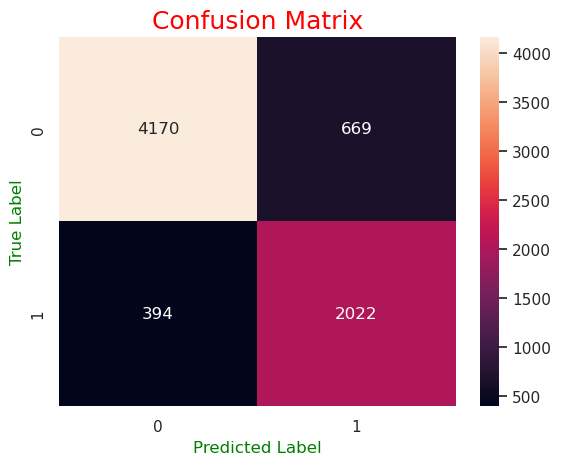

In [297]:
sns.heatmap(confusion_matrix(test_y,xgb.predict(test_x)), annot=True, fmt=".0f")
plt.title("Confusion Matrix", color = "red", fontsize=18)
plt.xlabel("Predicted Label", color = "green", fontsize = 12)
plt.ylabel("True Label", color = "green", fontsize = 12);

In [ ]:
accuracy_0 = confusion_matrix(test_y,xgb.predict(test_x))[0][0] / (confusion_matrix(test_y,xgb.predict(test_x))[0][0] + confusion_matrix(test_y,xgb.predict(test_x))[0][1])
accuracy_1 = confusion_matrix(test_y,xgb.predict(test_x))[1][1] / (confusion_matrix(test_y,xgb.predict(test_x))[1][0] + confusion_matrix(test_y,xgb.predict(test_x))[1][1])

print("Accuracy of Not Cancelled :",accuracy_0)
print("Accuracy of Cancelled :", accuracy_1)

Accuracy of Not Cancelled : 0.8617482951022939
Accuracy of Cancelled : 0.8369205298013245


### Logistic Regression

In [299]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(train_x_undersampled,train_y_undersampled)
print("Accuracy of Logistic Regression : % {}".format(logreg.score(test_x,test_y)*100))

Accuracy of Logistic Regression : % 78.37353549276361


In [300]:
print(classification_report(test_y,logreg.predict(test_x)))

              precision    recall  f1-score   support

         0.0       0.87      0.79      0.83      4839
         1.0       0.65      0.76      0.70      2416

    accuracy                           0.78      7255
   macro avg       0.76      0.78      0.77      7255
weighted avg       0.80      0.78      0.79      7255



### SVC

In [301]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(train_x_undersampled,train_y_undersampled)
print("Accuracy of SVC : % {}".format(svc.score(test_x,test_y)*100))

Accuracy of SVC : % 78.23569951757409


In [302]:
print(classification_report(test_y,svc.predict(test_x)))

              precision    recall  f1-score   support

         0.0       0.87      0.79      0.83      4839
         1.0       0.64      0.77      0.70      2416

    accuracy                           0.78      7255
   macro avg       0.76      0.78      0.77      7255
weighted avg       0.80      0.78      0.79      7255



### CatBoost Classifier

In [303]:
from catboost import CatBoostClassifier
cat = CatBoostClassifier(random_state=0,metric_period=100)
cat.fit(train_x_undersampled,train_y_undersampled)
print("Accuracy of CatBoost Classifier : % {}".format(cat.score(test_x,test_y)*100))

Learning rate set to 0.036171
0:	learn: 0.6711126	total: 3.11ms	remaining: 3.1s
100:	learn: 0.3966865	total: 224ms	remaining: 1.99s
100:	learn: 0.3966865	total: 224ms	remaining: 1.99s
200:	learn: 0.3711327	total: 452ms	remaining: 1.8s
200:	learn: 0.3711327	total: 452ms	remaining: 1.8s
300:	learn: 0.3538966	total: 678ms	remaining: 1.57s
300:	learn: 0.3538966	total: 678ms	remaining: 1.57s
400:	learn: 0.3393751	total: 904ms	remaining: 1.35s
400:	learn: 0.3393751	total: 904ms	remaining: 1.35s
500:	learn: 0.3282760	total: 1.13s	remaining: 1.13s
500:	learn: 0.3282760	total: 1.13s	remaining: 1.13s
600:	learn: 0.3192476	total: 1.38s	remaining: 915ms
600:	learn: 0.3192476	total: 1.38s	remaining: 915ms
700:	learn: 0.3114152	total: 1.6s	remaining: 684ms
700:	learn: 0.3114152	total: 1.6s	remaining: 684ms
800:	learn: 0.3042803	total: 1.83s	remaining: 454ms
800:	learn: 0.3042803	total: 1.83s	remaining: 454ms
900:	learn: 0.2980821	total: 2.05s	remaining: 225ms
900:	learn: 0.2980821	total: 2.05s	remai

In [304]:
print(classification_report(test_y,cat.predict(test_x)))

              precision    recall  f1-score   support

         0.0       0.91      0.87      0.89      4839
         1.0       0.76      0.83      0.79      2416

    accuracy                           0.86      7255
   macro avg       0.84      0.85      0.84      7255
weighted avg       0.86      0.86      0.86      7255



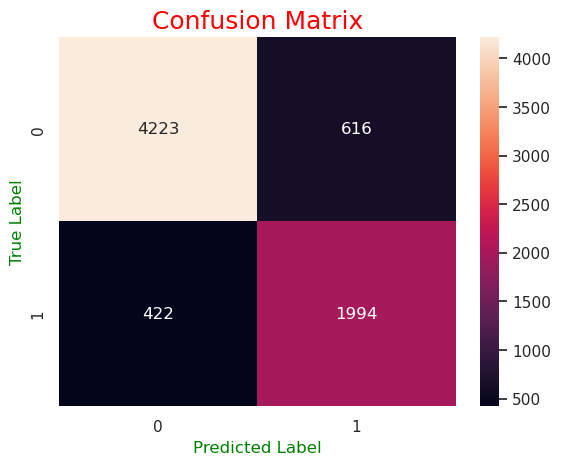

In [305]:
sns.heatmap(confusion_matrix(test_y,cat.predict(test_x)), annot=True, fmt=".0f")
plt.title("Confusion Matrix", color = "red", fontsize=18)
plt.xlabel("Predicted Label", color = "green", fontsize = 12)
plt.ylabel("True Label", color = "green", fontsize = 12);

### Inferences After Tried The Algorithms
* I tried some algorithms on this dataset and 3 of them worked well.
* These are Random Forest, XGB and CatBoost.
* In order to get better results i will benefit from these 3 algorithms by using ensemble learning with Voting Classifier.
* I hope i will get better results...

### Voting Classifier

>💡
**What is Voting Classifier**  
A Voting Classifier is a machine learning model that trains on an ensemble of numerous models and predicts an output (class) based on their highest probability of chosen class as the output.
> 

In [306]:
from sklearn.ensemble import VotingClassifier

voting = VotingClassifier(estimators=[("xgb",xgb),("rf_resampled",rf_sampled),("cat",cat)],
                          voting="soft",weights=[1,2.5,1.5])
voting.fit(train_x_undersampled,train_y_undersampled)
print("Accuracy of Voting Classifier : % {}".format(voting.score(test_x,test_y)*100))

Learning rate set to 0.036171
0:	learn: 0.6711126	total: 2.89ms	remaining: 2.89s
100:	learn: 0.3966865	total: 250ms	remaining: 2.22s
100:	learn: 0.3966865	total: 250ms	remaining: 2.22s
200:	learn: 0.3711327	total: 469ms	remaining: 1.86s
200:	learn: 0.3711327	total: 469ms	remaining: 1.86s
300:	learn: 0.3538966	total: 705ms	remaining: 1.64s
300:	learn: 0.3538966	total: 705ms	remaining: 1.64s
400:	learn: 0.3393751	total: 931ms	remaining: 1.39s
400:	learn: 0.3393751	total: 931ms	remaining: 1.39s
500:	learn: 0.3282760	total: 1.16s	remaining: 1.15s
500:	learn: 0.3282760	total: 1.16s	remaining: 1.15s
600:	learn: 0.3192476	total: 1.38s	remaining: 917ms
600:	learn: 0.3192476	total: 1.38s	remaining: 917ms
700:	learn: 0.3114152	total: 1.61s	remaining: 687ms
700:	learn: 0.3114152	total: 1.61s	remaining: 687ms
800:	learn: 0.3042803	total: 1.84s	remaining: 457ms
800:	learn: 0.3042803	total: 1.84s	remaining: 457ms
900:	learn: 0.2980821	total: 2.07s	remaining: 227ms
900:	learn: 0.2980821	total: 2.07s	

In [307]:
print(classification_report(test_y,voting.predict(test_x)))

              precision    recall  f1-score   support

         0.0       0.92      0.87      0.90      4839
         1.0       0.77      0.85      0.81      2416

    accuracy                           0.87      7255
   macro avg       0.85      0.86      0.85      7255
weighted avg       0.87      0.87      0.87      7255



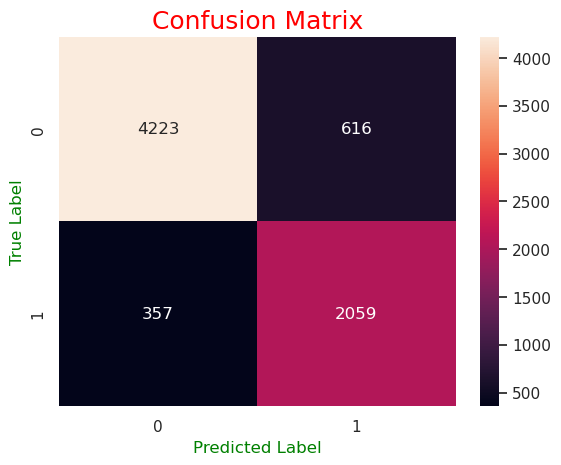

In [308]:
sns.heatmap(confusion_matrix(test_y,voting.predict(test_x)), annot=True, fmt=".0f")
plt.title("Confusion Matrix", color = "red", fontsize=18)
plt.xlabel("Predicted Label", color = "green", fontsize = 12)
plt.ylabel("True Label", color = "green", fontsize = 12);

In [ ]:
accuracy_0 = confusion_matrix(test_y,voting.predict(test_x))[0][0] / (confusion_matrix(test_y,voting.predict(test_x))[0][0] + confusion_matrix(test_y,voting.predict(test_x))[0][1])
accuracy_1 = confusion_matrix(test_y,voting.predict(test_x))[1][1] / (confusion_matrix(test_y,voting.predict(test_x))[1][0] + confusion_matrix(test_y,voting.predict(test_x))[1][1])

print("Accuracy of Not Cancelled :",accuracy_0)
print("Accuracy of Cancelled :", accuracy_1)

Accuracy of Not Cancelled : 0.8727009712750569
Accuracy of Cancelled : 0.8522350993377483


## Conclusion

This analysis systematically addressed class imbalance through multiple modeling approaches:

**Initial Model Development** commenced with Random Forest, which demonstrated strong overall accuracy but revealed significant class imbalance limitations upon deeper evaluation of per-class performance metrics.

**Class Imbalance Mitigation** was implemented via undersampling techniques, resulting in more balanced classification performance across both classes. While this approach reduced overall accuracy, it yielded a more reliable and equitable model, prioritizing balanced sensitivity and specificity over aggregate metrics.

**Ensemble Method Enhancement** was subsequently employed, incorporating multiple algorithms beyond Random Forest. This strategic combination leveraged the strengths of diverse models, producing superior predictive performance as anticipated.

**Comparative Analysis** extended to oversampling methodology, applying identical algorithmic frameworks for direct comparison. The evaluation yielded nuanced results:

- **Undersampling**: Specificity = 88%, Sensitivity = 86%
- **Oversampling**: Specificity = 90%, Sensitivity = 84%

**Final Assessment** indicates both sampling techniques effectively resolved the core class imbalance challenge. The marginal performance differentials suggest contextual appropriateness rather than categorical superiority. Depending on specific business requirements—whether prioritizing minimization of false negatives or false positives—either approach provides viable production-ready solutions.